In [1]:
# Install necessary dependencies (if not already installed)
# %pip install optuna  # Hyperparameter optimization library
# %pip install --upgrade scikit-learn  # Upgrade scikit-learn to the latest version
# %pip install trueskill  # TrueSkill rating system for ranking

# Predicting Box Office Earnings
This notebook aims to create a model that predicts box office earnings.

# Import the Relevant Libraries

In [2]:
# Standard library imports
import re
import warnings

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Scikit-learn preprocessing and utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    MultiLabelBinarizer,
    LabelEncoder,
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Regression models
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor

# Model evaluation metrics
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error,
)

# Feature selection and text processing
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Frequent pattern mining and statistical analysis
from mlxtend.frequent_patterns import apriori
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import skew, kurtosis, pearsonr, spearmanr

# TrueSkill ranking system
import trueskill as ts

# Optuna for hyperparameter optimization
import optuna
import optuna.visualization as vis

# Kaggle utilities
import kagglehub

# Display 500 columns for dataframes
pd.set_option("display.max_column", 200)

# Suppress warnings
warnings.filterwarnings("ignore")

# Load the Dataset

This dataset is sourced from **[Millions of Movies on Kaggle](https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies/data)**, which provides **metadata for over 700,000 movies** listed in the **TMDB (The Movie Database) dataset**. The dataset is **updated daily** and includes rich metadata such as:

## Key Features in the Dataset
- **Movie details:** Titles, release dates, languages, genres.
- **Financial data:** Budgets, revenues.
- **Production details:** Production companies, countries.
- **Ratings & reviews:** TMDB vote counts and vote averages.
- **Content metadata:** Plot keywords, recommendations, crew & cast details.

## Dataset Source & API
The dataset is compiled from the **TMDB Open API**, providing extensive movie data. However, it is **not officially endorsed or certified by TMDB**.

By leveraging this dataset, we can explore trends, build predictive models, and analyze the **factors that contribute to a movie's success**.

In [3]:
# Download dataset from KaggleHub
path = kagglehub.dataset_download("akshaypawar7/millions-of-movies")

# Load movies dataset
df_movies = pd.read_csv(f"{path}/movies.csv")

# Display first 5 rows
df_movies.head()

,id,title,genres,original_language,overview,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,keywords,poster_path,backdrop_path,recommendations
0,615656,Meg 2: The Trench,Action-Science Fiction-Horror,en,An exploratory dive into the deepest depths of...,8763.998,Apelles Entertainment-Warner Bros. Pictures-di...,2023-08-02,129000000.0,3.520565e+08,116.0,Released,Back for seconds.,7.079,1365.0,Jason Statham-Wu Jing-Shuya Sophia Cai-Sergio ...,based on novel or book-sequel-kaiju,/4m1Au3YkjqsxF8iwQy0fPYSxE0h.jpg,/qlxy8yo5bcgUw2KAmmojUKp4rHd.jpg,1006462-298618-569094-1061181-346698-1076487-6...
1,758323,The Pope's Exorcist,Horror-Mystery-Thriller,en,Father Gabriele Amorth Chief Exorcist of the V...,5953.227,Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...,2023-04-05,18000000.0,6.567582e+07,103.0,Released,Inspired by the actual files of Father Gabriel...,7.433,545.0,Russell Crowe-Daniel Zovatto-Alex Essoe-Franco...,spain-rome italy-vatican-pope-pig-possession-c...,/9JBEPLTPSm0d1mbEcLxULjJq9Eh.jpg,/hiHGRbyTcbZoLsYYkO4QiCLYe34.jpg,713704-296271-502356-1076605-1084225-1008005-9...
2,533535,Deadpool & Wolverine,Action-Comedy-Science Fiction,en,A listless Wade Wilson toils away in civilian ...,5410.496,Marvel Studios-Maximum Effort-21 Laps Entertai...,2024-07-24,200000000.0,1.326387e+09,128.0,Released,Come together.,7.765,3749.0,Ryan Reynolds-Hugh Jackman-Emma Corrin-Matthew...,hero-superhero-anti hero-mutant-breaking the f...,/8cdWjvZQUExUUTzyp4t6EDMubfO.jpg,/dvBCdCohwWbsP5qAaglOXagDMtk.jpg,573435-519182-957452-1022789-945961-718821-103...
3,667538,Transformers: Rise of the Beasts,Action-Adventure-Science Fiction,en,When a new threat capable of destroying the en...,5409.104,Skydance-Paramount-di Bonaventura Pictures-Bay...,2023-06-06,200000000.0,4.070455e+08,127.0,Released,Unite or fall.,7.340,1007.0,Anthony Ramos-Dominique Fishback-Luna Lauren V...,peru-alien-end of the world-based on cartoon-b...,/gPbM0MK8CP8A174rmUwGsADNYKD.jpg,/woJbg7ZqidhpvqFGGMRhWQNoxwa.jpg,496450-569094-298618-385687-877100-598331-4628...
4,693134,Dune: Part Two,Science Fiction-Adventure,en,Follow the mythic journey of Paul Atreides as ...,4742.163,Legendary Pictures,2024-02-27,190000000.0,6.838137e+08,167.0,Released,Long live the fighters.,8.300,2770.0,Timothée Chalamet-Zendaya-Rebecca Ferguson-Jav...,epic-based on novel or book-fight-sandstorm-sa...,/czembW0Rk1Ke7lCJGahbOhdCuhV.jpg,/xOMo8BRK7PfcJv9JCnx7s5hj0PX.jpg,438631-763215-792307-1011985-467244-634492-359...


In [4]:
print(f"Dataset shape: {df_movies.shape}")

Dataset shape: (722317, 20)


# Exploratory Data Analysis, Part 1: Initial Exploration and Filtering of Data Points

## Revenue

### Revenue Distribution Analysis

Before filtering, we need to check the distribution of movie revenues. Movie revenue is often **right-skewed**, meaning that **a small number of movies earn significantly more** than the rest.  

To visualize this, we plotted a histogram of revenue and calculated two key statistical measures:

- **Skewness**: Measures the asymmetry of the data distribution.
  - A **positive skewness (>1)** indicates a long tail on the right (few movies with very high revenue).
- **Kurtosis**: Measures the "tailedness" of the distribution.
  - A **high kurtosis** suggests that extreme values (blockbusters) strongly impact the dataset.

If revenue is highly skewed, removing low-revenue movies can improve analysis.


In [5]:
print("Revenue Statistics:")
print(df_movies["revenue"].describe())

Revenue Statistics:
count    7.223170e+05
mean     1.007747e+06
std      2.048321e+07
min     -1.200000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.920357e+09
Name: revenue, dtype: float64


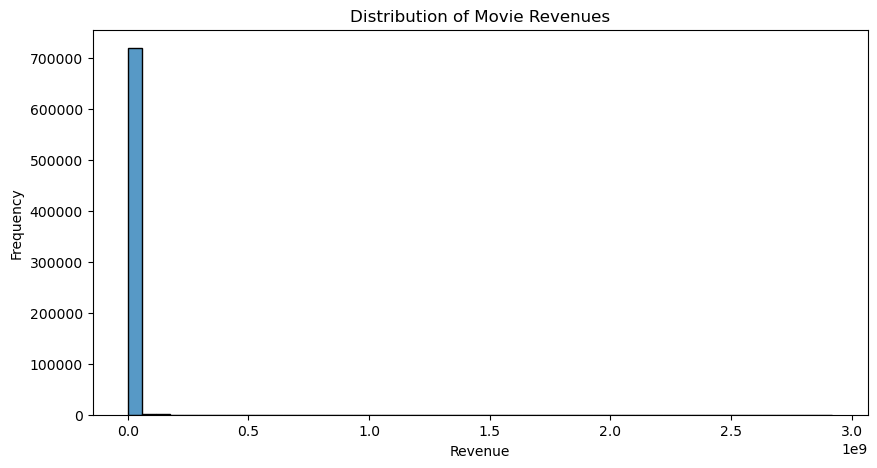

Skewness: 45.79
Kurtosis: 3269.52


In [6]:
# Plot revenue distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_movies["revenue"], bins=50, kde=False)
plt.xlabel("Revenue")
plt.ylabel("Frequency")
plt.title("Distribution of Movie Revenues")
plt.show()

# Check for skewness
print(f"Skewness: {df_movies["revenue"].skew():.2f}")
print(f"Kurtosis: {df_movies["revenue"].kurtosis():.2f}")

### Filtering High-Revenue Movies

Since the revenue distribution is **highly right-skewed**, we apply a **99th percentile filter** to keep only the **top 1% of movies**.

**Why filter the lower 99%?**
- **Focus on high-performing movies**: Most of the revenue in the industry is generated by a few blockbusters.
- **Avoid noise from small productions**: Many movies have very low or negligible earnings.
- **Improve model robustness**: If we are building a prediction model, training on high-revenue movies ensures better performance for blockbuster predictions.
- **Handle inaccurate or incomplete revenue records**: Some movies have **revenues recorded as `0` or `1`**, likely due to **poor tracking, limited releases, or missing data**. These data points distort the distribution and add unnecessary noise.
- **Ensure meaningful comparisons**: Keeping only the top 1% prevents **small, untracked films** from affecting insights about blockbuster trends.

By applying this filter, we create a dataset that focuses on **movies with substantial financial performance**, removing the influence of incomplete or irrelevant data.


In [7]:
# Count movies with revenue recorded as 0 or 1
zero_or_one_revenue = df_movies[df_movies["revenue"].isin([0, 1])]

# Display the count and some sample rows
print(f"Number of movies with revenue recorded as 0 or 1: {zero_or_one_revenue.shape[0]}")

Number of movies with revenue recorded as 0 or 1: 705280


In [8]:
# df_movies = df_movies[df_movies['revenue'] > 1]
# df_revenue_describe = df_movies["revenue"].describe()
# df_movies = df_movies.dropna(subset=["genres"])
# iqr = (df_revenue_describe["75%"] - df_revenue_describe["25%"]) * 1.5
# df_movies = df_movies[df_movies["revenue"] > df_revenue_describe["75%"] + iqr]
# #if greater than 3rd quartile + iqr = outlier
# #if 1st q -iqr = outlier

In [9]:
# # Store original dataset size and revenue statistics before filtering
# original_size = df_movies.shape[0]
# original_revenue_stats = df_movies["revenue"].describe()

# # Compute IQR-based threshold
# iqr = (original_revenue_stats["75%"] - original_revenue_stats["25%"]) * 1.5
# upper_threshold = original_revenue_stats["75%"] + iqr

# # Create a new filtered dataframe excluding movies below the IQR threshold
# df_movies_1 = df_movies[df_movies["revenue"] > upper_threshold]

# # Display filter results
# print(f"Original dataset size: {original_size}")
# print(f"Filtered dataset size: {df_movies_1.shape[0]}")
# print(f"Movies removed: {original_size - df_movies_1.shape[0]}")


In [10]:
# Store original dataset size and revenue statistics before filtering
original_size = df_movies.shape[0]
original_revenue_stats = df_movies["revenue"].describe()

# Identify the 99th percentile revenue threshold
top_1_percent_value = df_movies["revenue"].quantile(0.99)

# Create a new filtered dataframe for the top 1% revenue movies
df_movies_1 = df_movies[df_movies["revenue"] >= top_1_percent_value]

# Display filter results
print(f"Original dataset size: {original_size}")
print(f"Filtered dataset size: {df_movies_1.shape[0]}")
print(f"Movies removed: {original_size - df_movies_1.shape[0]}")

Original dataset size: 722317
Filtered dataset size: 7224
Movies removed: 715093


In [11]:
# Count movies with revenue recorded as 0 or 1
zero_or_one_revenue = df_movies_1[df_movies_1["revenue"].isin([0, 1])]

# Display the count and some sample rows
print(f"Number of movies with revenue recorded as 0 or 1: {zero_or_one_revenue.shape[0]}")

Number of movies with revenue recorded as 0 or 1: 0


### Comparing Revenue Before and After Filtering

To ensure that our filtering step was **effective**, we compare key statistics **before and after** applying the 99th percentile filter.

**What are we checking?**
- **Mean & Median Revenue**: Should increase significantly after filtering.
- **Min & Max Revenue**: Ensures we only kept **blockbusters**.
- **Number of Movies Removed**: Helps quantify the impact of filtering.

This comparison justifies our choice to remove lower-revenue movies and confirms that our dataset now focuses on **high-grossing films**.

In [12]:
# Store updated dataset size and revenue statistics after filtering
filtered_size = df_movies_1.shape[0]
filtered_revenue_stats = df_movies_1["revenue"].describe()

# Compare statistics before and after filtering
print("Original Revenue Statistics:")
print(original_revenue_stats)

print("\nFiltered Revenue Statistics:")
print(filtered_revenue_stats)

# Show how many movies were removed
print(f"\nOriginal dataset size: {original_size}")
print(f"Filtered dataset size: {filtered_size}")
print(f"Movies removed: {original_size - filtered_size}")

Original Revenue Statistics:
count    7.223170e+05
mean     1.007747e+06
std      2.048321e+07
min     -1.200000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.920357e+09
Name: revenue, dtype: float64

Filtered Revenue Statistics:
count    7.224000e+03
mean     9.895587e+07
std      1.796056e+08
min      7.033500e+06
25%      1.517758e+07
50%      3.569646e+07
75%      1.005237e+08
max      2.920357e+09
Name: revenue, dtype: float64

Original dataset size: 722317
Filtered dataset size: 7224
Movies removed: 715093


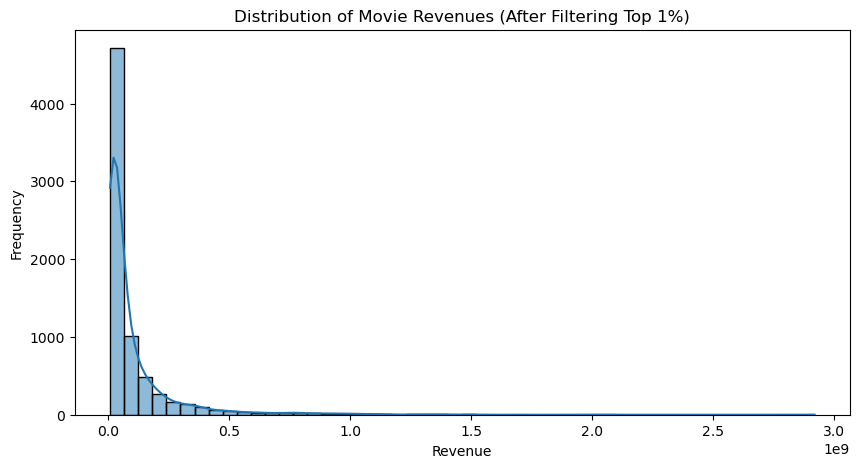

In [13]:
# Visualizing the revenue distribution AFTER filtering

# Set figure size
plt.figure(figsize=(10, 5))

# Plot histogram with KDE (Kernel Density Estimate) to show distribution
sns.histplot(df_movies_1["revenue"], bins=50, kde=True)

# Add labels and title
plt.xlabel("Revenue")
plt.ylabel("Frequency")
plt.title("Distribution of Movie Revenues (After Filtering Top 1%)")

# Show the plot
plt.show()

In [14]:
print("Column Data Types:")
print(df_movies_1.dtypes)

Column Data Types:
id                        int64
title                    object
genres                   object
original_language        object
overview                 object
popularity              float64
production_companies     object
release_date             object
budget                  float64
revenue                 float64
runtime                 float64
status                   object
tagline                  object
vote_average            float64
vote_count              float64
credits                  object
keywords                 object
poster_path              object
backdrop_path            object
recommendations          object
dtype: object


In [15]:
# Convert release_date to datetime format, coercing errors to NaT (if any invalid dates exist)
df_movies_1["release_date"] = pd.to_datetime(df_movies_1["release_date"], errors="coerce")

# Get the earliest and latest release dates
earliest_date = df_movies_1["release_date"].min()
latest_date = df_movies_1["release_date"].max()

# Display the results
print(f"Earliest release date: {earliest_date}")
print(f"Latest release date: {latest_date}")

Earliest release date: 1915-02-08 00:00:00
Latest release date: 2024-10-22 00:00:00


### Revenue Distribution - Box Plot

The box plot shows that **most movies** have revenues **at the lower end**, with only a few earning extremely high amounts. This reveals a **heavily right-skewed distribution** with a **significant number of outliers**.

**Key Observations:**
- The **median revenue** is positioned near the lower end, meaning **half of all movies earn relatively little**.
- The **interquartile range (IQR)** is very small, indicating that **most movies cluster around low revenues**.
- A **long upper whisker** and many **outliers** suggest that a **small number of blockbuster films** earn exponentially more than the majority.
- Some movies have **recorded revenues as `0` or `1`**, likely due to **poor tracking, missing data, or very limited releases**. These data points **heavily compress the lower end of the distribution**.
- This confirms the **huge revenue gap** between **average movies** and **major hits**, while also highlighting potential data inconsistencies.

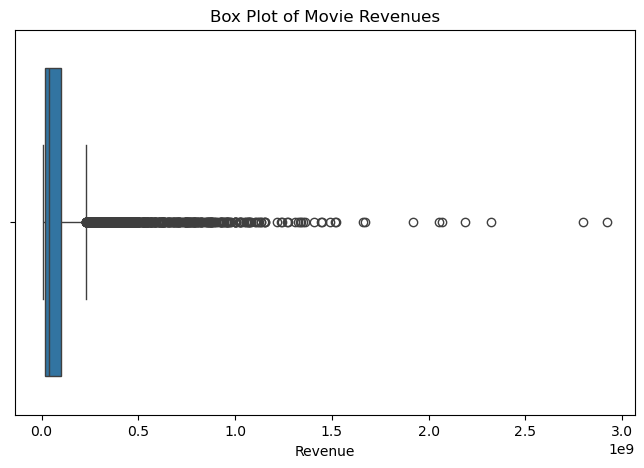

In [16]:
# Box plot to visualize the distribution of movie revenues
plt.figure(figsize=(8, 5))

# Create a horizontal box plot of revenue
sns.boxplot(x=df_movies_1["revenue"])

# Add title and labels
plt.title("Box Plot of Movie Revenues")
plt.xlabel("Revenue")

# Display the plot
plt.show()

### Revenue Distribution - Line Plot

This plot shows movie revenues **sorted in ascending order**, helping us visualize how revenue is distributed across movies.

**Key Observations:**
- The revenue curve remains **nearly flat** for most of the dataset, confirming that **most movies earn relatively little**.
- A **sharp rise at the end** indicates that a **small fraction of movies (blockbusters) earn dramatically more**.
- This confirms the **power-law distribution** commonly seen in movie revenues—where **a few movies dominate earnings while most struggle**.

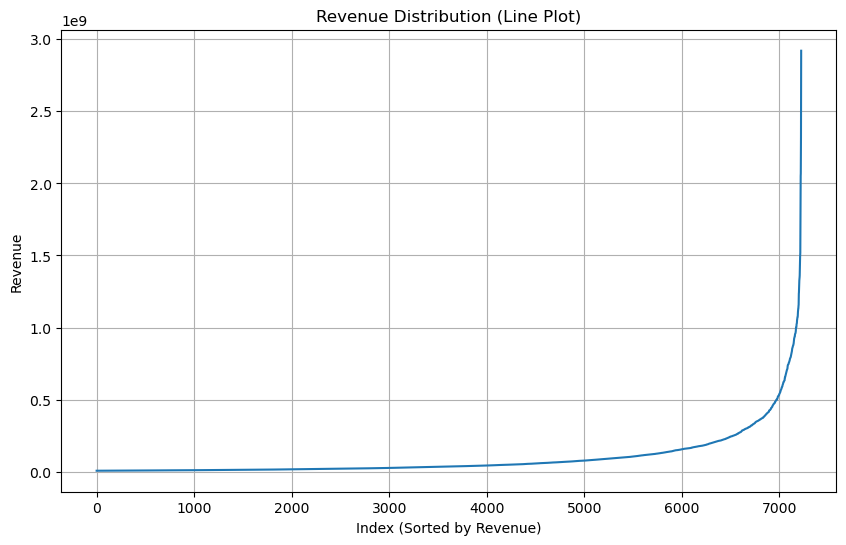

In [17]:
# Line plot of sorted revenue values to visualize distribution
plt.figure(figsize=(10, 6))

# Plot sorted revenue values (excluding NaNs)
plt.plot(sorted(df_movies_1["revenue"].dropna().values))

# Add title and labels
plt.title("Revenue Distribution (Line Plot)")
plt.xlabel("Index (Sorted by Revenue)")
plt.ylabel("Revenue")

# Enable grid for better readability
plt.grid(True)

# Display the plot
plt.show()

### Revenue Distribution - Log Scale

To better visualize differences among **lower-revenue movies**, we apply a **log scale** to the revenue values.

**Key Observations:**
- Unlike the regular plot, the log-transformed version **spreads out lower-revenue movies**, making trends more visible.
- The revenue curve appears **more linear**, confirming an **exponential revenue distribution**.
- This transformation helps **highlight smaller revenue differences** that were otherwise hidden in the previous plot.
- It also reinforces that **blockbusters earn exponentially more than regular movies**.

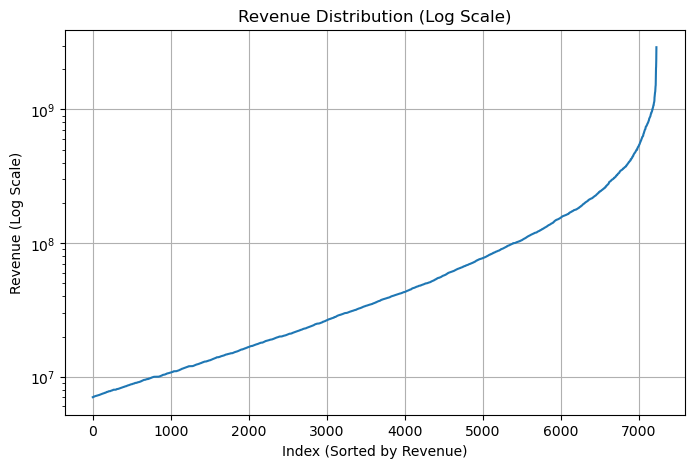

In [18]:
# Line plot of sorted revenue values with log scale for better visualization
plt.figure(figsize=(8, 5))

# Plot sorted revenue values
plt.plot(sorted(df_movies_1["revenue"].dropna().values))

# Apply logarithmic scale to Y-axis
plt.yscale("log")

# Add title and labels
plt.title("Revenue Distribution (Log Scale)")
plt.xlabel("Index (Sorted by Revenue)")
plt.ylabel("Revenue (Log Scale)")

# Enable grid for better readability
plt.grid(True)

# Display the plot
plt.show()

## Budget

### Budget Distribution - Box Plot

This box plot reveals a **highly skewed distribution** of movie budgets, with most films having **relatively small budgets clustered near the lower end**, while a few **blockbuster productions stand out as extreme outliers** with exceptionally high budgets.

**Key Observations:**
- The **median budget** is positioned near the lower end, indicating that **most films operate with limited resources**.
- A **tight interquartile range (IQR)** suggests that **many movies have similar budget constraints**.
- A **long upper whisker** and multiple **outliers** highlight that **a handful of big-budget films dominate the upper range**.
- Some movies may have **recorded budgets as `0` or `1`**, likely due to **missing data or lack of accurate reporting**.
- The large gap between the **main data cluster and these outliers** emphasizes the industry's **budget disparity**, where **a small number of high-budget productions receive the majority of financial investment**.

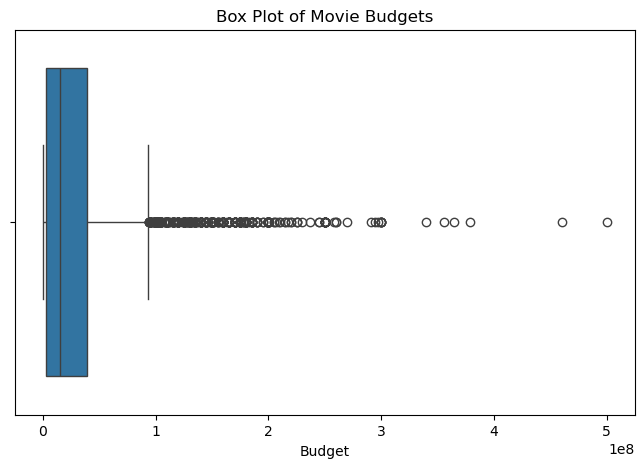

In [19]:
# Box plot to visualize the distribution of movie budgets
plt.figure(figsize=(8, 5))

# Create a horizontal box plot of budgets
sns.boxplot(x=df_movies_1["budget"])

# Add title and labels
plt.title("Box Plot of Movie Budgets")
plt.xlabel("Budget")

# Display the plot
plt.show()

To ensure a meaningful budget analysis, we filter out movies with a **budget of 0** since these entries likely represent **missing or untracked data**.

**Why Remove Movies with Zero Budget?**
- **Data Accuracy:** Movies with a `budget = 0` likely have incomplete or unreliable financial records.
- **Improved Insights:** Retaining only movies with reported budgets ensures a more accurate distribution.
- **Better Visualization:** The box plot previously showed an **extremely skewed distribution**, which is influenced by a large number of zero-budget movies.

After filtering, we analyze the **adjusted budget distribution**.

In [20]:
# Count movies with revenue recorded as 0 or 1
zero_or_one_revenue = df_movies_1[df_movies_1["budget"].isin([0, 1])]

# Display the count and some sample rows
print(f"Number of movies with revenue recorded as 0 or 1: {zero_or_one_revenue.shape[0]}")

Number of movies with revenue recorded as 0 or 1: 1239


In [21]:
# Create a new filtered dataframe excluding movies with zero budget
df_movies_2 = df_movies_1[df_movies_1["budget"] > 1].reset_index(drop=True)

# Display the number of remaining movies
print(f"Dataset size after removing movies with zero budget: {len(df_movies_2)}")

Dataset size after removing movies with zero budget: 5985


In [22]:
# Count movies with revenue recorded as 0 or 1
zero_or_one_revenue = df_movies_2[df_movies_2["budget"].isin([0, 1])]

# Display the count and some sample rows
print(f"Number of movies with revenue recorded as 0 or 1: {zero_or_one_revenue.shape[0]}")

Number of movies with revenue recorded as 0 or 1: 0


### Budget Distribution - Log Scale

This plot shows **movie budgets sorted in ascending order**, with a **logarithmic scale applied to the Y-axis** after filtering out movies with a budget of zero.

**Key Observations:**
- The **initial flat portion** seen before filtering has disappeared, confirming that all zero-budget movies have been removed.
- The **gradual slope** indicates that most movies have **relatively low to mid-range budgets**, with a steady increase.
- The **steeper rise at the end** highlights that a small number of **high-budget productions dominate the industry**.
- Applying a **log scale** allows us to better visualize **budget differences among smaller and mid-range films**, which would otherwise be compressed in a standard linear plot.

By filtering out movies with zero budgets, the distribution now provides a **more accurate view of actual production spending** across different films.


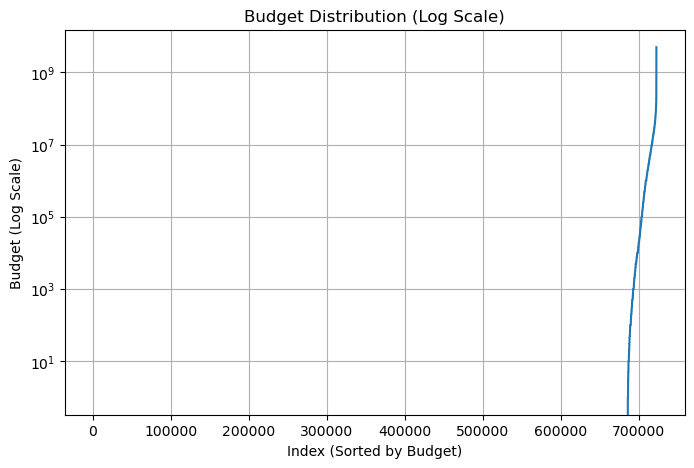

In [23]:
# Plot budget distribution with log scale
plt.figure(figsize=(8, 5))

# Plot sorted budget values
plt.plot(sorted(df_movies["budget"]))

# Apply logarithmic scale to the Y-axis
plt.yscale("log")

# Add title and labels
plt.title("Budget Distribution (Log Scale)")
plt.xlabel("Index (Sorted by Budget)")
plt.ylabel("Budget (Log Scale)")

# Enable grid for better readability
plt.grid(True)

# Display the plot
plt.show()

## Status ("Released", "Rumored", "Post Production", "In Production")

In [24]:
# Count the number of movies for each status category
df_movies_2["status"].value_counts()

status
Released           5981
Rumored               2
Post Production       1
In Production         1
Name: count, dtype: int64

The dataset includes movies with different production statuses, such as **"Released," "Rumored," "Post Production," and "In Production."** Since we are analyzing **movies that have actually been released**, we filter out all entries **except those with a "Released" status.**

In [25]:
# Create a filtered dataframe keeping only movies with status "Released"
print(f"Length before filtering: {len(df_movies_1)}")

df_movies_3 = df_movies_2[df_movies_2["status"] == "Released"]

print(f"Length after filtering: {len(df_movies_3)}")

Length before filtering: 7224
Length after filtering: 5981


## Release Year

To analyze the distribution of movie releases over time, we extract the **release year** from the `release_date` column and visualize it using a histogram. This helps us identify **trends in movie production**, such as peaks in certain decades or declines due to industry shifts.

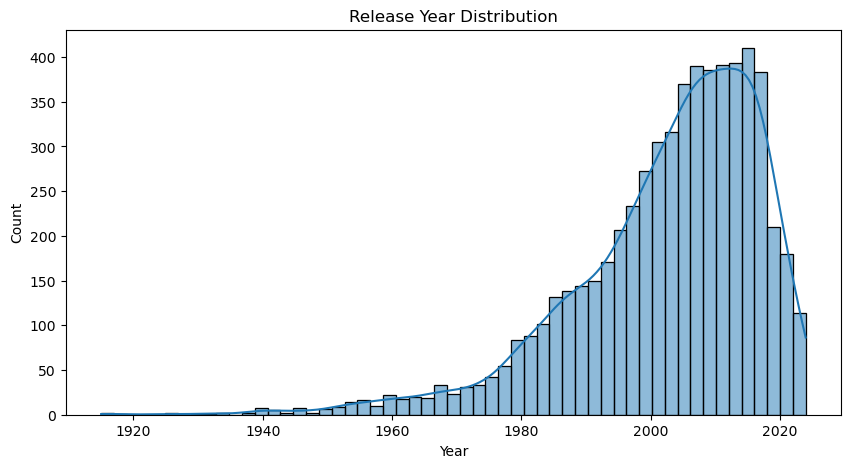

In [26]:
# Extract release year from release_date
df_movies_3["release_year"] = df_movies_3["release_date"].dt.year

# Plot histogram of release years with density estimation
plt.figure(figsize=(10, 5))
sns.histplot(df_movies_3["release_year"], kde=True)

# Add title and labels
plt.title("Release Year Distribution")
plt.xlabel("Year")
plt.ylabel("Count")

# Show the plot
plt.show()

This histogram shows the distribution of movie releases over time.

**Key Observations:**
- **Early Years (Pre-1960s):** Very few movies were recorded, likely due to limited data availability or the smaller film industry at the time.
- **Gradual Increase (1960s-1980s):** A steady rise in the number of films released, reflecting the growth of the film industry.
- **Major Growth (1990s-2010s):** A significant increase in movie production, coinciding with:
  - The rise of multiplex cinemas.
  - Advances in digital filmmaking, making production more accessible.
  - The globalization of the film industry, leading to higher output.
- **Peak Around 2015-2019:** The highest number of releases occurred during this period, suggesting a boom in content creation.
- **Recent Decline (Post-2020):** A sharp drop in movie releases, likely due to:
  - The **COVID-19 pandemic**, which disrupted productions.
  - The **shift to streaming services**, reducing theatrical releases.
  - Possible data collection gaps for very recent years.

This distribution highlights how **technological advancements, industry expansion, and global events** influence movie production trends.


## Summary Statistics

## Summary Statistics

We compute summary statistics to understand the dataset.

**Numerical Summary**
- Provides measures like mean, median, min/max, and quartiles for numeric columns.
- Helps identify skewness, extreme values, and outliers.

**Categorical Summary**
- Shows counts of unique values and most frequent categories.
- Useful for assessing category distributions and identifying dominant values.

These statistics provide a baseline for further analysis and data preprocessing.

In [27]:
# Summary statistics for numerical columns
df_movies_3.describe()

,id,popularity,release_date,budget,revenue,runtime,vote_average,vote_count,release_year
count,5981.000000,5981.000000,5951,5.981000e+03,5.981000e+03,5981.000000,5981.000000,5981.000000,5951.000000
mean,127494.383715,43.521257,2003-03-25 03:06:04.779028864,3.673727e+07,1.125752e+08,112.509614,6.497670,2338.217188,2002.690640
min,6.000000,0.600000,1915-02-08 00:00:00,1.100000e+01,7.033500e+06,0.000000,0.000000,0.000000,1915.000000
25%,9357.000000,11.419000,1995-12-22 00:00:00,8.765230e+06,1.819561e+07,97.000000,6.000000,331.000000,1995.000000
50%,16288.000000,17.608000,2006-06-23 00:00:00,2.000000e+07,4.428713e+07,108.000000,6.587000,1055.000000,2006.000000
75%,177699.000000,30.995000,2013-12-25 00:00:00,4.500000e+07,1.200000e+08,123.000000,7.100000,2744.000000,2013.000000
max,968051.000000,8763.998000,2024-10-22 00:00:00,5.000000e+08,2.920357e+09,999.000000,10.000000,34857.000000,2024.000000
std,203061.843868,236.568277,NaN,4.515471e+07,1.923912e+08,29.167056,0.996373,3575.455616,14.764638


In [28]:
# Summary statistics for categorical columns
df_movies_3.describe(include="object")

,title,genres,original_language,overview,production_companies,status,tagline,credits,keywords,poster_path,backdrop_path,recommendations
count,5981,5951,5981,5968,5875,5981,5318,5962,5714,5964,5895,5477
unique,5816,1490,37,5927,4892,1,5284,5922,5633,5922,5871,5455
top,Shaft,Comedy,en,Julius Fonteneau has decided to take the law i...,Paramount,Released,Your worst fear comes true,Prithviraj Sukumaran-Priya Anand-Sujith Sankar...,woman director,/quKVGPffv7dTxqToe4084P7qVqj.jpg,/sjzilg0o3Ynd1kbQi6xUdrw7JfY.jpg,404665-263494
freq,3,335,5112,3,76,5981,3,3,14,3,3,3


# Data Cleaning, Part 1

## Filtering Animated Movies

To focus on animated movies, we apply sequential filters.

1. **Select Movies Tagged as "Animation"**  
   - Filters movies where the `genres` column contains "Animation."
   - Uses `df_movies_3` as the source dataset to maintain consistency.

2. **Remove Movies with Missing Revenue or Budget**  
   - Drops entries with `revenue = 0` or `budget = 0` to ensure financial data is meaningful.

3. **Filter for 21st Century Releases**  
   - Keeps only movies released in or after the year 2000.

These steps refine the dataset for more relevant analysis.

In [29]:
# Select movies with "Animation" in the genres column
df_animation = df_movies_3[df_movies_3["genres"].notna() & df_movies_3["genres"].str.contains("Animation")]

# Display first five rows
df_animation.head(5)

,id,title,genres,original_language,overview,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,keywords,poster_path,backdrop_path,recommendations,release_year
9,519182,Despicable Me 4,Animation-Family-Comedy-Action,en,Gru and Lucy and their girls—Margo Edith and A...,3195.720,Universal Pictures-Illumination-dentsu-Fuji Te...,2024-06-20,100000000.0,810329715.0,94.0,Released,Things just got a little more despicable.,7.350,984.0,Steve Carell-Kristen Wiig-Will Ferrell-Sofía V...,superhero-villain-sequel-super villain-illumin...,/wWba3TaojhK7NdycRhoQpsG0FaH.jpg,/lgkPzcOSnTvjeMnuFzozRO5HHw1.jpg,748783-1022789-1023922-533535-1114738-718821-5...,2024.0
10,569094,Spider-Man: Across the Spider-Verse,Action-Adventure-Animation-Science Fiction,en,After reuniting with Gwen Stacy Brooklyn’s ful...,2550.738,Columbia Pictures-Sony Pictures Animation-Lord...,2023-05-31,100000000.0,512609552.0,140.0,Released,It's how you wear the mask that matters,8.640,1684.0,Shameik Moore-Hailee Steinfeld-Brian Tyree Hen...,sacrifice-villain-comic book-sequel-superhero-...,/8Vt6mWEReuy4Of61Lnj5Xj704m8.jpg,/4HodYYKEIsGOdinkGi2Ucz6X9i0.jpg,496450-667538-385687-603692-298618-447277-9765...,2023.0
26,315162,Puss in Boots: The Last Wish,Animation-Family-Fantasy-Adventure-Comedy,en,Puss in Boots discovers that his passion for a...,904.250,DreamWorks Animation-Universal Pictures,2022-12-07,90000000.0,480000000.0,103.0,Released,Say hola to his little friends.,8.284,5759.0,Antonio Banderas-Salma Hayek Pinault-Harvey Gu...,fairy tale-talking dog-spin off-aftercreditsst...,/kuf6dutpsT0vSVehic3EZIqkOBt.jpg,/jr8tSoJGj33XLgFBy6lmZhpGQNu.jpg,943822-1033456-505642-1011679-1058949-100088-1...,2022.0
27,748783,The Garfield Movie,Animation-Comedy-Family-Adventure-Action,en,Garfield the world-famous Monday-hating lasagn...,813.181,Alcon Entertainment-DNEG-Wayfarer Studios-One ...,2024-04-30,60000000.0,221871392.0,101.0,Released,Indoor cat. Outdoor adventure.,7.179,815.0,Chris Pratt-Samuel L. Jackson-Hannah Waddingha...,friendship-cat-villain-based on comic-lasagne-...,/xYduFGuch9OwbCOEUiamml18ZoB.jpg,/1wP1phHo2CROOqzv7Azs0MT5esU.jpg,1093995-974262-653346-639720-1197406-1207898-1...,2024.0
28,940551,Migration,Animation-Action-Adventure-Comedy-Family,en,After a migrating duck family alights on their...,800.053,Illumination,2023-12-06,72000000.0,289076685.0,83.0,Released,Odd ducks welcome.,7.563,1009.0,Kumail Nanjiani-Elizabeth Banks-Caspar Jenning...,duck-migration-flight-anthropomorphism-family-...,/ldfCF9RhR40mppkzmftxapaHeTo.jpg,/meyhnvssZOPPjud4F1CjOb4snET.jpg,609681-572802-1022796-866398-787699-930564-845...,2023.0


In [30]:
# Display the number of animated movies
df_animation.shape

(384, 21)

In [31]:
# Track dataset size before filtering by release year
print("Length before filtering year:", len(df_animation))

# Create a new filtered dataframe for 21st-century animated movies
df_animation_1 = df_animation[df_animation["release_date"].dt.year >= 2000]

# Display dataset size after filtering
print("Length covering the 21st century:", len(df_animation_1))

Length before filtering year: 384
Length covering the 21st century: 314


In [32]:
# Display column names in the filtered animated movies dataset
df_animation_1.columns

Index(['id', 'title', 'genres', 'original_language', 'overview', 'popularity',
       'production_companies', 'release_date', 'budget', 'revenue', 'runtime',
       'status', 'tagline', 'vote_average', 'vote_count', 'credits',
       'keywords', 'poster_path', 'backdrop_path', 'recommendations',
       'release_year'],
      dtype='object')

# EDA, Part 2: Feature Selection

## Numerical

**Pearson Correlation Analysis**

Pearson correlation measures the **linear relationship** between two numerical variables. It ranges from **-1 to 1**, where:
- **1.0**: Perfect positive correlation (as one variable increases, the other increases)
- **-1.0**: Perfect negative correlation (as one variable increases, the other decreases)
- **0.0**: No correlation (no linear relationship)

We compute Pearson correlation between **revenue** and key numerical features:  
- **Budget**: To assess whether higher production budgets result in higher revenue.
- **Runtime**: To check if movie length impacts revenue.

### Revenue Analysis

We examine revenue distribution and its correlation with budget and runtime.

In [33]:
top_10_revenue = df_animation_1[["title", "revenue"]].sort_values(by="revenue", ascending=False).head(10)
lowest_10_revenue = df_animation_1[["title", "revenue"]].sort_values(by="revenue").head(10)

print("Top 10 Revenue Entries:\n", top_10_revenue)
print("\nLowest 10 Revenue Entries:\n", lowest_10_revenue)

Top 10 Revenue Entries:
                             title       revenue
387                     Frozen II  1.450000e+09
85    The Super Mario Bros. Movie  1.362000e+09
211                        Frozen  1.274219e+09
578                 Incredibles 2  1.242805e+09
1467                      Minions  1.156731e+09
259                   Toy Story 4  1.073395e+09
307                   Toy Story 3  1.067316e+09
1318              Despicable Me 3  1.031553e+09
1388                 Finding Dory  1.028571e+09
216                      Zootopia  1.023784e+09

Lowest 10 Revenue Entries:
                                           title    revenue
4372                                   Donkey X  7365250.0
3652                           A Scanner Darkly  7659918.0
2810                        An Egg-celent movie  7800000.0
3948                         Ernest & Celestine  8109160.0
4479                     The Fixies: Top Secret  8220990.0
3879                           Capture the Flag  8306690.0
4161 

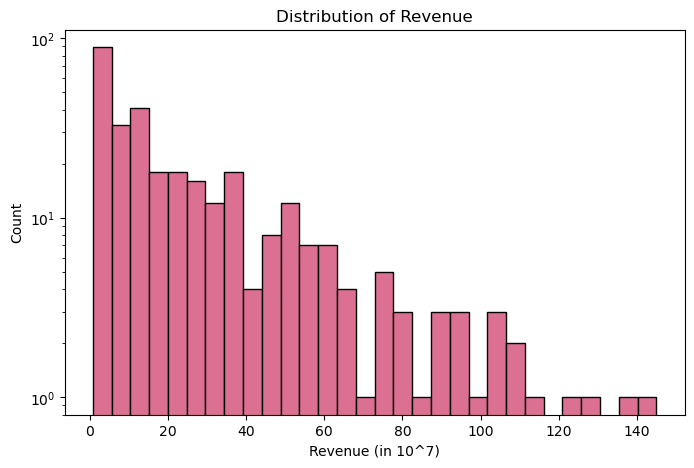

In [34]:
plt.figure(figsize=(8, 5))
plt.hist(df_animation_1["revenue"] / 10**7, bins=30, color="palevioletred", edgecolor="black")
plt.title("Distribution of Revenue")
plt.xlabel("Revenue (in 10^7)")
plt.ylabel("Count")
plt.yscale("log")
plt.xticks(range(0, int(df_animation_1["revenue"].max() / 10**7) + 1, 20))
plt.show()

### Budget Analysis

We analyze budget distribution and compute its correlation with revenue.

In [35]:
top_10_budget = df_animation_1[["title", "budget"]].sort_values(by="budget", ascending=False).head(10)
lowest_10_budget = df_animation_1[["title", "budget"]].sort_values(by="budget").head(10)

print("Top 10 Budget Entries:\n", top_10_budget)
print("\nLowest 10 Budget Entries:\n", lowest_10_budget)

Top 10 Budget Entries:
                              title       budget
5760  Mega Man X: The Day of Sigma  300000000.0
364                        Tangled  260000000.0
346                      Lightyear  200000000.0
307                    Toy Story 3  200000000.0
424              A Christmas Carol  200000000.0
188                           Luca  200000000.0
578                  Incredibles 2  200000000.0
590            Monsters University  200000000.0
1388                  Finding Dory  200000000.0
848                         Onward  200000000.0

Lowest 10 Budget Entries:
                                           title     budget
5951                          Little Tikes Land   100000.0
2810                        An Egg-celent movie   800000.0
664                  The Last: Naruto the Movie   903852.0
1574                   Dragon Ball Super: Broly  1000000.0
5912  Чародей равновесия. Тайна Сухаревой башни  1133865.0
4374                          Waltz with Bashir  1500000.0
3408   

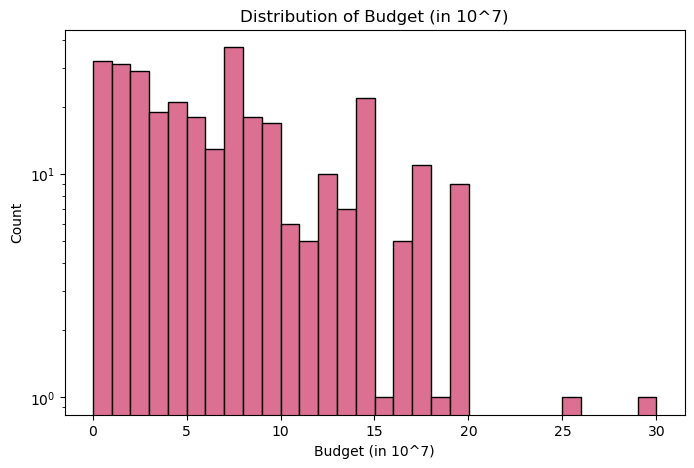

In [36]:
plt.figure(figsize=(8, 5))
plt.hist(df_animation_1["budget"] / 10**7, bins=30, color="palevioletred", edgecolor="black")
plt.title("Distribution of Budget (in 10^7)")
plt.xlabel("Budget (in 10^7)")
plt.ylabel("Count")
plt.yscale("log")  # Log scale for better visibility
plt.show()

In [37]:
# Copy dataset and remove missing values
df_animation_2 = df_animation_1[["budget", "revenue"]].dropna()

# Compute Pearson correlation and p-value
corr_budget, p_value_budget = pearsonr(df_animation_2["budget"], df_animation_2["revenue"])

# Display results
print(f"Pearson Correlation between Budget and Revenue: {corr_budget:.4f}")
print(f"P-value: {p_value_budget:.4f}")

Pearson Correlation between Budget and Revenue: 0.5926
P-value: 0.0000


### Runtime Analysis

We explore the distribution of runtime and its correlation with revenue.

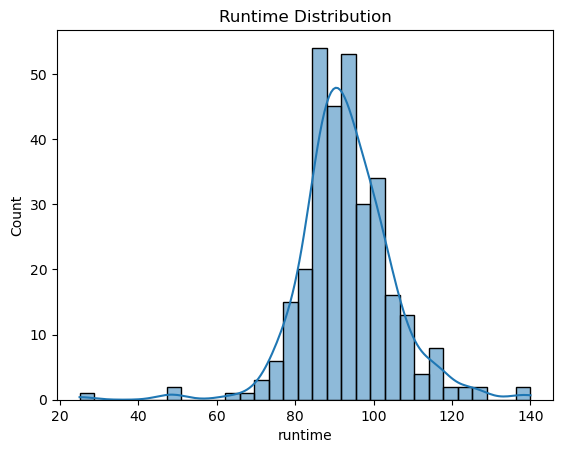

In [38]:
sns.histplot(df_animation_1["runtime"], kde=True)
plt.title("Runtime Distribution")
plt.show()

In [39]:
# Copy dataset
df_animation_3 = df_animation_1.copy()

# Fill missing runtime values with the median
df_animation_3["runtime"].fillna(df_animation_3["runtime"].median(), inplace=True)

# Remove rows with missing revenue values
df_animation_3 = df_animation_3[["runtime", "revenue"]].dropna()

# Compute Pearson correlation and p-value
corr_runtime, p_value_runtime = pearsonr(df_animation_3["runtime"], df_animation_3["revenue"])

# Display results
print(f"Pearson Correlation between Runtime and Revenue: {corr_runtime:.4f}")
print(f"P-value: {p_value_runtime:.4f}")

Pearson Correlation between Runtime and Revenue: 0.2325
P-value: 0.0000


### Year of Release

In [40]:
# Convert release date column to datetime format, coercing errors to NaT
df_animation_1["release_date"] = pd.to_datetime(
    df_animation_1["release_date"], errors="coerce"
)

# Find the earliest and latest release dates
earliest_date_anim = df_animation_1["release_date"].min()
latest_date_anim = df_animation_1["release_date"].max()

# Print the earliest and latest release dates
print(f"Earliest release date: {earliest_date_anim}")
print(f"Latest release date: {latest_date_anim}")

Earliest release date: 2000-02-11 00:00:00
Latest release date: 2024-06-20 00:00:00


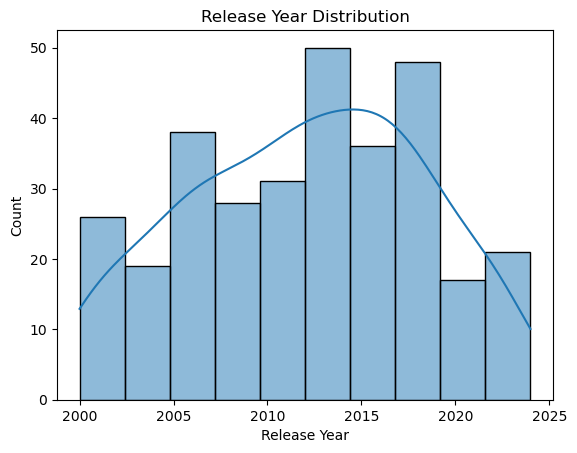

In [41]:
# Extract release year from the release date column
df_animation_1["release_year"] = df_animation_1["release_date"].dt.year

# Plot the release year distribution
sns.histplot(df_animation_1["release_year"], kde=True)
plt.title("Release Year Distribution")
plt.xlabel("Release Year")
plt.ylabel("Count")
plt.show()

In [42]:
# Copy dataset and extract release year
df_animation_4 = df_animation_1.copy()
df_animation_4["release_year"] = df_animation_4["release_date"].dt.year

# Drop rows with missing values in release_year or revenue
df_animation_4 = df_animation_4[["release_year", "revenue"]].dropna()

# Compute Spearman correlation and p-value
corr_year, p_value_year = spearmanr(df_animation_4["release_year"], df_animation_4["revenue"])

# Display results
print(f"Spearman Correlation between Release Year and Revenue: {corr_year:.4f}")
print(f"P-value: {p_value_year:.4f}")

Spearman Correlation between Release Year and Revenue: 0.0504
P-value: 0.3732


### Feature Selection

**Kept Features**
- **Budget (Correlation = 0.5926)**  
  A moderate-to-strong positive correlation suggests that higher budgets are associated with higher revenue. Larger budgets typically allow for better production, marketing, and distribution, leading to increased earnings.

- **Runtime (Correlation = 0.2325)**  
  A weak-to-moderate positive correlation indicates that longer movies may generate slightly higher revenue, likely due to higher production value. However, the effect is less direct than budget, as longer runtimes can also limit daily screenings.

**Dropped Features**
- **Release year**
    
    Release year will not be included because its **high p-value (0.3732)** indicate **no meaningful relationship** with revenue; instead, **seasonal timing (quarters) is a more actionable and predictive feature** for movie success. Release year is not actionable because studios cannot release a movie in the past. Instead, seasonal timing (quarters) is more relevant and will be explored in the Feature Engineering section of this notebook, as studios can strategically choose when to release a film (e.g., summer, holiday season).

## Categorical

**General Function for Splitting Delimited Strings**
  
The function `split_delimited_string` standardizes and processes delimited categorical data. It ensures consistency by replacing commas with hyphens before splitting the string into a list. This is useful for categorical features that store multiple values in a single column.

In [43]:
def dash_str_to_list(value):
    """Converts a delimited string into a list, unifying delimiters before splitting."""
    if isinstance(value, str):
        return value.replace(",", "-").split("-")  # Unify delimiters before splitting
    return []

### Genre  

This section processes and analyzes the `genres` column in the dataset. It includes transforming genre strings into lists, analyzing genre distributions, and evaluating their impact on revenue using Mutual Information (MI).

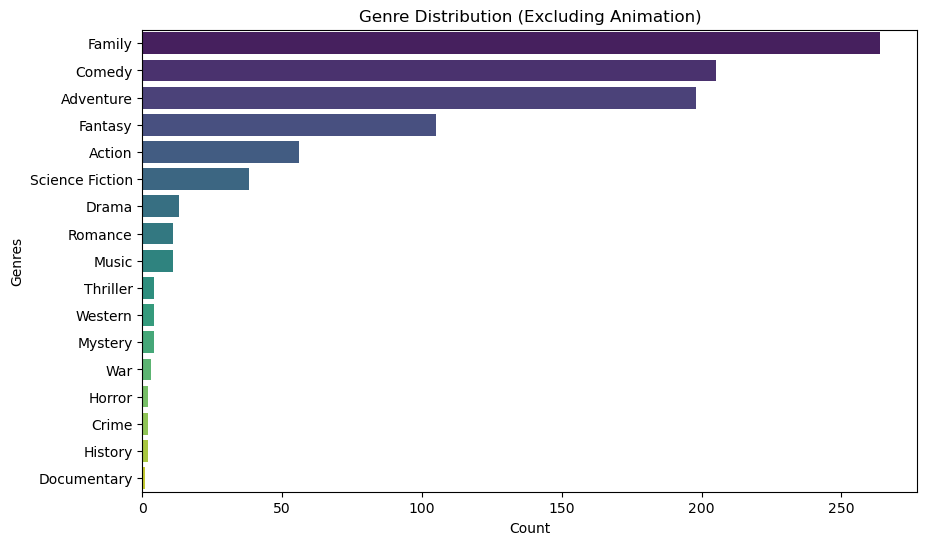

In [44]:
df_animation_1["genres_list"] = df_animation_1["genres"].apply(dash_str_to_list)

exploded_df_genre = df_animation_1.explode("genres_list")

genre_counts = exploded_df_genre["genres_list"].value_counts()
filtered_genre_count = genre_counts.drop("Animation")

plt.figure(figsize=(10, 6))
sns.barplot(x=filtered_genre_count.values, y=filtered_genre_count.index, palette="viridis")
plt.title("Genre Distribution (Excluding Animation)")
plt.xlabel("Count")
plt.ylabel("Genres")
plt.show()

In [45]:
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df_animation_1["genres_list"])

df_genre_encoded = pd.DataFrame(genre_encoded, columns=mlb.classes_, index=df_animation_1.index)

df_animation_1["revenue"].fillna(0, inplace=True)
revenue_scaled = StandardScaler().fit_transform(df_animation_1[["revenue"]])

mi_scores_genre = mutual_info_regression(df_genre_encoded, revenue_scaled.ravel())

mi_scores_df_genre = pd.DataFrame({"Genre": mlb.classes_, "MI_Score": mi_scores_genre})
mi_scores_df_sorted_genre = mi_scores_df_genre.sort_values(by="MI_Score", ascending=False)

print(mi_scores_df_sorted_genre)

              Genre      MI_Score
3            Comedy  4.765286e-02
1         Adventure  3.421186e-02
14  Science Fiction  3.292807e-02
8           Fantasy  1.848464e-02
11            Music  1.727970e-02
7            Family  1.688048e-02
6             Drama  1.099554e-02
17          Western  3.413944e-03
12          Mystery  2.427906e-03
4             Crime  1.051396e-03
5       Documentary  6.661338e-16
2         Animation  2.220446e-16
0            Action  0.000000e+00
9           History  0.000000e+00
13          Romance  0.000000e+00
10           Horror  0.000000e+00
15         Thriller  0.000000e+00
16              War  0.000000e+00


### Original Language
Analyzing the distribution and predictive value of the original language in animated films.

In [46]:
# Count occurrences of each original language
language_counts = df_animation_1["original_language"].value_counts()
print(language_counts)

original_language
en    255
ja     23
fr     13
es     10
zh      6
ru      4
de      1
he      1
it      1
Name: count, dtype: int64


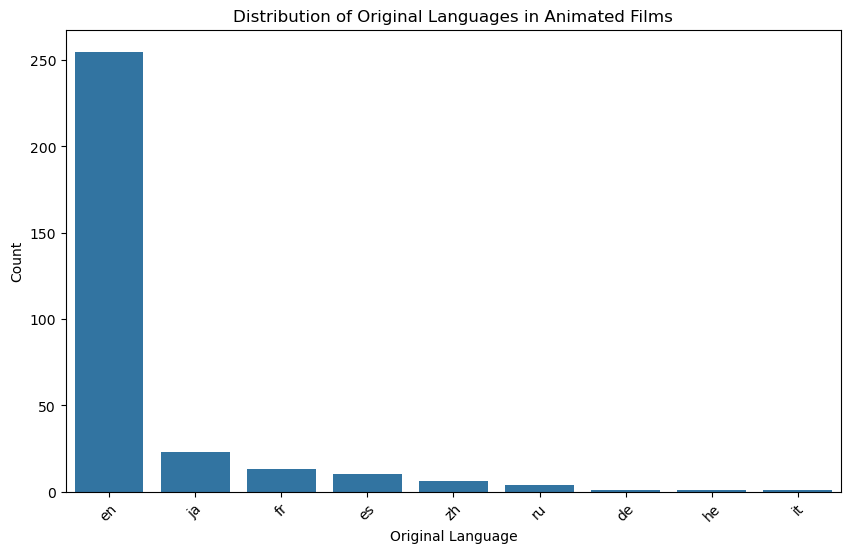

In [47]:
# Plot the distribution of original languages
plt.figure(figsize=(10, 6))
sns.barplot(
    x=language_counts.index,
    y=language_counts.values
)

plt.title("Distribution of Original Languages in Animated Films")
plt.xlabel("Original Language")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

In [48]:
# Filter movies that are not in English
non_english_movies = df_animation_1[df_animation_1["original_language"] != "en"]

# Select relevant columns and sort by revenue in descending order
non_english_sorted = non_english_movies[
    ["title", "original_language", "revenue", "budget"]
].sort_values(by="revenue", ascending=False)

# Display the top 10 highest-revenue non-English animated movies
non_english_sorted.head(5)

,title,original_language,revenue,budget
2154,Ne Zha,zh,742500000.0,20000000.0
43,Demon Slayer -Kimetsu no Yaiba- The Movie: Mug...,ja,503063688.0,15800000.0
5760,Mega Man X: The Day of Sigma,ja,428000000.0,300000000.0
76,The Boy and the Heron,ja,294200000.0,50000000.0
427,Spirited Away,ja,274925095.0,19000000.0


In [49]:
# Copy dataframe for MI analysis
MI_lang = df_animation_1.copy()

# Handle missing values
MI_lang["original_language"].fillna("unknown", inplace=True)
MI_lang["revenue"].fillna(0, inplace=True)

# Encode original language using LabelEncoder
le = LabelEncoder()
language_encoded = le.fit_transform(MI_lang["original_language"]).reshape(-1, 1)

# Standardize revenue
revenue_scaled = StandardScaler().fit_transform(MI_lang[["revenue"]])

# Compute mutual information score for original language
mi_score_language = mutual_info_regression(language_encoded, revenue_scaled.ravel())[0]

print(f"MI Score for Original Language: {mi_score_language:.5f}")

# Encode genres using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(MI_lang["genres_list"])

# Convert to DataFrame
df_genre_encoded = pd.DataFrame(
    genre_encoded, columns=mlb.classes_, index=MI_lang.index
)

# Compute mutual information scores for genres
mi_scores_genre = mutual_info_regression(df_genre_encoded, revenue_scaled.ravel())

# Store and sort MI scores
mi_scores_df_genre = pd.DataFrame({"Genre": mlb.classes_, "MI_Score": mi_scores_genre})
mi_scores_df_sorted_genre = mi_scores_df_genre.sort_values(by="MI_Score", ascending=False)

# Display sorted MI scores
print(mi_scores_df_sorted_genre)

MI Score for Original Language: 0.17368
              Genre      MI_Score
3            Comedy  4.765286e-02
1         Adventure  3.421186e-02
14  Science Fiction  3.292807e-02
8           Fantasy  1.848464e-02
11            Music  1.727970e-02
7            Family  1.688048e-02
6             Drama  1.099554e-02
17          Western  3.413944e-03
12          Mystery  2.427906e-03
4             Crime  1.051396e-03
5       Documentary  6.661338e-16
2         Animation  2.220446e-16
0            Action  0.000000e+00
9           History  0.000000e+00
13          Romance  0.000000e+00
10           Horror  0.000000e+00
15         Thriller  0.000000e+00
16              War  0.000000e+00


### Production Companies
Production companies impact budget, distribution, and marketing, all of which affect revenue.

In [50]:
# Convert production company strings to lists
df_animation_1["production_companies_list"] = df_animation_1["production_companies"].apply(
    dash_str_to_list
)

# Explode the dataframe so that each production company gets its own row
df_exploded_prod = df_animation_1.explode("production_companies_list")

# Compute total revenue per production company and sort by descending revenue
df_prod_rev_anim = (
    df_exploded_prod.groupby("production_companies_list")["revenue"]
    .sum()
    .reset_index()
    .sort_values(by="revenue", ascending=False)
)

# Select the top 25 highest-revenue production companies
top_20_companies_anim = df_prod_rev_anim.head(25)

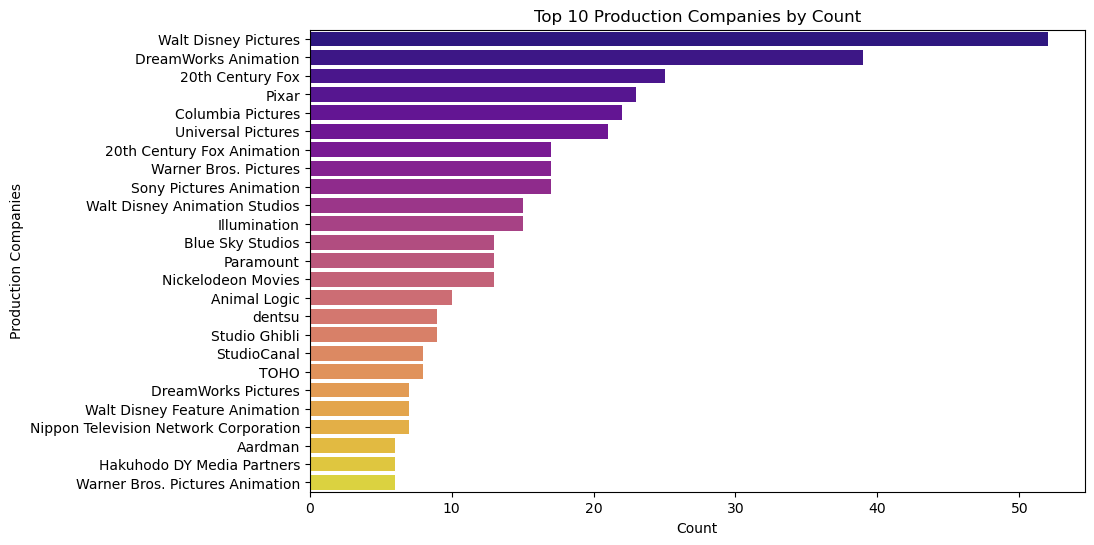

In [51]:
production_counts = df_exploded_prod["production_companies_list"].value_counts()
top_production_counts = production_counts.head(25)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_production_counts.values, y=top_production_counts.index, palette="plasma")

plt.title("Top 10 Production Companies by Count")
plt.xlabel("Count")
plt.ylabel("Production Companies")
plt.show()

In [52]:
# Encode production companies using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
companies_encoded = mlb.fit_transform(df_animation_1["production_companies_list"])

# Convert to DataFrame
df_companies_encoded = pd.DataFrame(
    companies_encoded, columns=mlb.classes_, index=df_animation_1.index
)

# Handle missing revenue values
df_animation_1["revenue"].fillna(0, inplace=True)

# Standardize revenue for MI computation
scaler = StandardScaler()
revenue_scaled = scaler.fit_transform(df_animation_1[["revenue"]])

# Compute mutual information scores for production companies
mi_scores_companies = mutual_info_regression(df_companies_encoded, revenue_scaled.ravel())

# Store and sort MI scores
mi_scores_df_companies = pd.DataFrame(
    {"Production_Company": mlb.classes_, "MI_Score": mi_scores_companies}
)
mi_scores_df_sorted_companies = mi_scores_df_companies.sort_values(
    by="MI_Score", ascending=False
)

# Display sorted MI scores
print(mi_scores_df_sorted_companies)

            Production_Company  MI_Score
132       DreamWorks Animation  0.054763
104          Columbia Pictures  0.038153
209               Illumination  0.037866
335                      Pixar  0.035529
66            Blue Sky Studios  0.034361
..                         ...       ...
30            Arad Productions  0.000000
32   Aronnax Animation Studios  0.000000
33    Assemblage Entertainment  0.000000
34                  Atresmedia  0.000000
35        Audiovisual Aval SGR  0.000000

[505 rows x 2 columns]


### Actor

In [53]:
# Convert credits column into a list format
df_animation_1["credits_list"] = df_animation_1["credits"].apply(dash_str_to_list)

# Explode the dataframe so each actor gets their own row
df_exploded_credits = df_animation_1.explode("credits_list")

# Aggregate revenue by actor and calculate average revenue
actor_avg_revenue = (
    df_exploded_credits.groupby("credits_list")["revenue"]
    .mean()
    .reset_index()
    .rename(columns={"credits_list": "Actor", "revenue": "avg_revenue"})
)

# Sort actors by highest average revenue
actor_avg_revenue_sorted = actor_avg_revenue.sort_values(by="avg_revenue", ascending=False)

In [54]:
# Retrieve average revenue for Chris Evans as an example
actor_avg_revenue_sorted[actor_avg_revenue_sorted["Actor"] == "Chris Evans"]

,Actor,avg_revenue
962,Chris Evans,161017207.5


In [55]:
# Copy the dataset for MI analysis
MI_actors = df_animation_1.copy()

# Convert credits column to a list of actors
MI_actors["actors_list"] = MI_actors["credits"].apply(dash_str_to_list)

# One-hot encode the actors
mlb = MultiLabelBinarizer()
MI_actors_encoded = mlb.fit_transform(MI_actors["actors_list"])

# Convert encoded data to a DataFrame
MI_actors_df = pd.DataFrame(
    MI_actors_encoded, columns=mlb.classes_, index=MI_actors.index
)

# Handle missing revenue values
MI_actors["revenue"].fillna(0, inplace=True)

# Standardize revenue for MI computation
scaler = StandardScaler()
revenue_scaled = scaler.fit_transform(MI_actors[["revenue"]])

# Compute mutual information scores for actors
mi_scores_actors = mutual_info_regression(MI_actors_df, revenue_scaled.ravel())

# Store and sort MI scores
mi_scores_df_actors = pd.DataFrame({
    "Actor": mlb.classes_,
    "MI_Score": mi_scores_actors
}).sort_values(by="MI_Score", ascending=False)

# Display sorted MI scores
print(mi_scores_df_actors)

                  Actor  MI_Score
5212       Steve Coogan  0.053665
2715  John Ratzenberger  0.045899
4501      Pierre Coffin  0.039688
2893      Julie Andrews  0.039098
340          Anna Faris  0.038077
...                 ...       ...
5832    Zooey Deschanel  0.000000
5834       Zoë Crawford  0.000000
5835        Zoë Kravitz  0.000000
5836           Zoë Raye  0.000000
5837               hyun  0.000000

[5849 rows x 2 columns]


### Feature Selection

**Kept Features**
- **Genre**: Genres show moderate mutual information with revenue, meaning they contribute to revenue variability. Certain genres like Comedy, Adventure, and Science Fiction have higher MI scores, making them relevant predictors.
- **Original Language**: With an MI score of **0.1698**, original language shows a stronger relationship with revenue than many other categorical variables, indicating that language can influence market reach and earnings.
- **Production Companies**: Some production companies (e.g., DreamWorks, Pixar) exhibit notable MI scores, meaning the reputation and resources of production studios impact revenue. Companies with a track record of successful films contribute predictive power.
- **Actors**: Certain actors (e.g., Steve Coogan, John Ratzenberger) have nonzero MI scores, suggesting that star power affects revenue. Well-known actors can attract larger audiences, making this a meaningful feature.

## Textual Data
Analyzing how textual features, such as movie overviews and keywords, relate to revenue.

### Overview
Extracting key terms from **movie summaries** using TF-IDF and assessing their predictive power.

In [56]:
# Copy dataset for MI analysis
MI_overview = df_animation_1.copy()

# Handle missing values
MI_overview["overview"].fillna("", inplace=True)
MI_overview["revenue"].fillna(0, inplace=True)

# Vectorize movie overviews using TF-IDF (filters common words)
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
overview_vectorized = vectorizer.fit_transform(MI_overview["overview"]).toarray()

# Standardize revenue for MI computation
scaler = StandardScaler()
revenue_scaled = scaler.fit_transform(MI_overview[["revenue"]])

# Compute mutual information scores for TF-IDF terms
mi_scores_overview = mutual_info_regression(overview_vectorized, revenue_scaled.ravel())

# Store results in a DataFrame
mi_df_overview = pd.DataFrame({
    "Term": vectorizer.get_feature_names_out(),
    "MI Score": mi_scores_overview
})

# Sort MI scores in descending order
mi_df_sorted_overview = mi_df_overview.sort_values(
    by="MI Score", ascending=False
).reset_index(drop=True)

# Display top terms with the highest MI scores
print("Top Terms in Movie Overviews with Highest MI with Revenue:")
print(mi_df_sorted_overview.head(20))

Top Terms in Movie Overviews with Highest MI with Revenue:
         Term  MI Score
0       world  0.020150
1       finds  0.018589
2         new  0.017398
3         gru  0.016036
4        town  0.015266
5      forest  0.015127
6      forces  0.015119
7         boy  0.014398
8     central  0.013511
9     biggest  0.013457
10  adventure  0.012931
11      space  0.011643
12       time  0.010807
13      takes  0.010549
14       care  0.009949
15       soon  0.009899
16       hero  0.008539
17     planet  0.008086
18     rabbit  0.008050
19       high  0.006961


### Keyword
Extracting significant **movie keywords** and assessing their predictive power for revenue.

In [57]:
# Copy dataset for MI analysis
MI_key = df_animation_1.copy()

# Handle missing values
MI_key["keywords"].fillna("", inplace=True)
MI_key["revenue"].fillna(0, inplace=True)

# Vectorize keywords using CountVectorizer (limits features for efficiency)
vectorizer = CountVectorizer(max_features=1000)
keywords_vectorized = vectorizer.fit_transform(MI_key["keywords"]).toarray()

# Standardize revenue for MI computation
scaler = StandardScaler()
revenue_scaled = scaler.fit_transform(MI_key[["revenue"]])

# Compute mutual information scores for keywords
mi_scores_keywords = mutual_info_regression(keywords_vectorized, revenue_scaled.ravel())

# Store results in a DataFrame
mi_df_keywords = pd.DataFrame({
    "Keyword": vectorizer.get_feature_names_out(),
    "MI Score": mi_scores_keywords
})

# Sort MI scores in descending order
mi_df_sorted_keywords = mi_df_keywords.sort_values(
    by="MI Score", ascending=False
).reset_index(drop=True)

# Display top keywords with the highest MI scores
print("Top Keywords with Highest MI with Revenue:")
print(mi_df_sorted_keywords.head(20))

Top Keywords with Highest MI with Revenue:
                 Keyword  MI Score
0                 sequel  0.105286
1   duringcreditsstinger  0.065979
2                 animal  0.054453
3                minions  0.038911
4                  anime  0.027018
5                   stop  0.025242
6                singing  0.025112
7                 flying  0.023672
8           illumination  0.023533
9                 dragon  0.022221
10                  post  0.022040
11               cartoon  0.021490
12          relationship  0.021362
13              director  0.020508
14                motion  0.019999
15                    in  0.019718
16                 magic  0.019456
17                  arts  0.018605
18               martial  0.018605
19                   and  0.018382


### Feature Selection

- **Keywords will be included** as they exhibit higher mutual information scores with revenue. The top keyword, *sequel*, has an MI score of **0.105**, which is quite strong for textual data. Other meaningful keywords, such as *animal*, *minions*, and *anime*, also indicate that specific themes and elements in movies are predictive of revenue.

- **Overview will be excluded** because its mutual information scores fall within the **0.01–0.02** range, suggesting only a weak relationship with revenue. While certain words like *world* and *finds* appear frequently, they do not provide strong predictive power compared to keywords.

## Summary Statistics

In [58]:
# Display summary statistics for numerical features
df_animation_1.describe()

,id,popularity,release_date,budget,revenue,runtime,vote_average,vote_count,release_year
count,314.000000,314.000000,314,3.140000e+02,3.140000e+02,314.000000,314.000000,314.000000,314.000000
mean,191172.015924,80.992248,2012-07-19 20:19:52.356687872,7.458393e+07,2.557931e+08,93.181529,6.749997,3565.130573,2012.025478
min,12.000000,0.666000,2000-02-11 00:00:00,1.000000e+05,7.365250e+06,25.000000,0.000000,0.000000,2000.000000
25%,12877.500000,19.845500,2007-08-19 00:00:00,2.902500e+07,4.864025e+07,87.000000,6.200000,547.750000,2007.000000
50%,88422.500000,34.299000,2012-12-19 12:00:00,7.000000e+07,1.472687e+08,92.000000,6.800000,1996.500000,2012.000000
75%,333345.000000,65.665750,2017-06-15 00:00:00,1.022500e+08,3.606189e+08,100.000000,7.373000,4934.000000,2017.000000
max,940551.000000,3195.720000,2024-06-20 00:00:00,3.000000e+08,1.450000e+09,140.000000,8.640000,21482.000000,2024.000000
std,208205.123067,247.576585,NaN,5.584439e+07,2.806181e+08,11.898755,0.867582,4214.438584,6.253892


In [59]:
# Display summary statistics for categorical (object) features
df_animation_1.describe(include="object")

,title,genres,original_language,overview,production_companies,status,tagline,credits,keywords,poster_path,backdrop_path,recommendations,genres_list,production_companies_list,credits_list
count,314,314,314,314,309,314,278,314,306,313,313,305,314,314,314
unique,314,177,9,314,224,1,278,314,301,313,313,305,177,225,314
top,Little Tikes Land,Animation-Comedy-Family,en,Little Tikes Land includes 4 CGI-animated stor...,DreamWorks Animation,Released,Join the little tikes in their magical adventu...,Phillip Corlett-Brooklyn Chang-Jason Michas-Ja...,anime,/3Kt4IOflyR9ZQUk30Zu2WN1Lmd3.jpg,/3MrBmx9IuulMGanHPucXgyxDqRi.jpg,33534-154922-33065-314946-451172-83865-9907-13...,"[Animation, Comedy, Family]",[DreamWorks Animation],"[Phillip Corlett, Brooklyn Chang, Jason Michas..."
freq,1,17,255,1,16,314,1,1,4,1,1,1,17,16,1


# Data Cleaning, Part 2

## Filtering Relevant Columns

To streamline the dataset, we retain only the most relevant columns needed for analysis. This includes identifiers, textual descriptions, financial data, and categorical attributes. By removing unnecessary columns, we improve efficiency and focus on features that contribute to meaningful insights.

After filtering, we check the **shape** of the dataset to confirm the changes.

In [60]:
# Select relevant columns and remove irrelevant ones
df_animation_5 = df_animation_1[[
    "id", "title", "genres", "original_language", "overview",
    "production_companies", "release_date", "budget", "revenue",
    "runtime", "credits", "keywords"
]]

df_animation_5.head(5)

,id,title,genres,original_language,overview,production_companies,release_date,budget,revenue,runtime,credits,keywords
9,519182,Despicable Me 4,Animation-Family-Comedy-Action,en,Gru and Lucy and their girls—Margo Edith and A...,Universal Pictures-Illumination-dentsu-Fuji Te...,2024-06-20,100000000.0,810329715.0,94.0,Steve Carell-Kristen Wiig-Will Ferrell-Sofía V...,superhero-villain-sequel-super villain-illumin...
10,569094,Spider-Man: Across the Spider-Verse,Action-Adventure-Animation-Science Fiction,en,After reuniting with Gwen Stacy Brooklyn’s ful...,Columbia Pictures-Sony Pictures Animation-Lord...,2023-05-31,100000000.0,512609552.0,140.0,Shameik Moore-Hailee Steinfeld-Brian Tyree Hen...,sacrifice-villain-comic book-sequel-superhero-...
26,315162,Puss in Boots: The Last Wish,Animation-Family-Fantasy-Adventure-Comedy,en,Puss in Boots discovers that his passion for a...,DreamWorks Animation-Universal Pictures,2022-12-07,90000000.0,480000000.0,103.0,Antonio Banderas-Salma Hayek Pinault-Harvey Gu...,fairy tale-talking dog-spin off-aftercreditsst...
27,748783,The Garfield Movie,Animation-Comedy-Family-Adventure-Action,en,Garfield the world-famous Monday-hating lasagn...,Alcon Entertainment-DNEG-Wayfarer Studios-One ...,2024-04-30,60000000.0,221871392.0,101.0,Chris Pratt-Samuel L. Jackson-Hannah Waddingha...,friendship-cat-villain-based on comic-lasagne-...
28,940551,Migration,Animation-Action-Adventure-Comedy-Family,en,After a migrating duck family alights on their...,Illumination,2023-12-06,72000000.0,289076685.0,83.0,Kumail Nanjiani-Elizabeth Banks-Caspar Jenning...,duck-migration-flight-anthropomorphism-family-...


In [61]:
# Display the shape of the cleaned dataset
df_animation_2.shape

(314, 2)

# Feature Engineering

The succeeding steps taken for feature engineering ensures that the dataset captures **important patterns and relationships** that a model can learn from.  

For this dataset, we focus on:  
- **Date-Based Features**: Extracting **release quarters** to capture **seasonal effects** on revenue.  
- **Categorical Features**: Encoding **genres, production companies, original language, and actors** to reflect their impact on revenue.  
- **Text Features**: Using **keywords** to represent thematic elements that influence movie success.  

These transformations help improve **interpretability** and allow models to make better revenue predictions based on actionable insights.


## Date-Based Features

To capture **seasonal trends** in movie performance, we extract the **release quarter** from the release date. Certain quarters may influence revenue due to **seasonal demand**, such as:
- **Q1** (January–March): Post-holiday releases and early-year animated films.
- **Q2** (April–June): Start of the summer blockbuster season.
- **Q3** (July–September): Peak summer releases and early fall films.
- **Q4** (October–December): Holiday and award-season releases.

By encoding **release quarters** instead of **release years**, it will allow studios to **strategically time movie releases** for maximum revenue. Since **release year is uncontrollable**, focusing on **quarters** helps in planning **marketing campaigns, distribution strategies, and production schedules**. For example, a **family-friendly animated movie** may perform better in **Q4 (holiday season)**, while an **action-packed franchise film** might be best suited for **Q2 (summer blockbusters)**.

In [62]:
# Sort the dataset by 'release_date'
df_animation_5 = df_animation_1.sort_values(by="release_date", ignore_index=True)

# Convert release_date to datetime format
df_animation_5["release_date"] = pd.to_datetime(df_animation_5["release_date"])

# Extract the quarter and map it to categorical labels
df_animation_5["release_quarter"] = df_animation_5["release_date"].dt.quarter.map(
    {1: "q1", 2: "q2", 3: "q3", 4: "q4"}
)

# One-hot encode the quarters
df_animation_5 = pd.get_dummies(df_animation_5, columns=["release_quarter"], prefix="quarter")

# Ensure quarter columns are treated as integers
df_animation_5[["quarter_q1", "quarter_q2", "quarter_q3", "quarter_q4"]] = df_animation_5[
    ["quarter_q1", "quarter_q2", "quarter_q3", "quarter_q4"]
].astype(int)

# Display the first 5 rows
df_animation_5.head(5)

,id,title,genres,original_language,overview,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,keywords,poster_path,backdrop_path,recommendations,release_year,genres_list,production_companies_list,credits_list,quarter_q1,quarter_q2,quarter_q3,quarter_q4
0,15655,The Tigger Movie,Family-Animation-Comedy,en,Winnie the Pooh Piglet Owl Kanga Roo and Rabbi...,20.167,Walt Disney Pictures-Disney Television Animati...,2000-02-11,30000000.0,45554533.0,77.0,Released,NaN,6.500,487.0,Jim Cummings-Ken Sansom-John Fiedler-Peter Cul...,woman director,/lxuiGvLHIL1ZyePP7bn6FcKj0Mr.jpg,/uMoSM7r4dst4e5aFUhDEDPyh1hL.jpg,13691-13682-13706-16394-27332-14885-326911-511...,2000,"[Family, Animation, Comedy]","[Walt Disney Pictures, Disney Television Anima...","[Jim Cummings, Ken Sansom, John Fiedler, Peter...",1,0,0,0
1,20455,Digimon: The Movie,Fantasy-Animation-Science Fiction-Family,ja,The first story focused on Tai and Kari Kamiya...,13.017,Saban Entertainment-Toei Company-Fox Family Fi...,2000-03-04,5500000.0,16600000.0,89.0,Released,New Monsters. New Battles. Now on the Big Screen.,6.600,243.0,Lara Jill Miller-Joshua Seth-Bob Papenbrook-Da...,video game-monster-loss of energy-computer-sup...,/1MpgVWRCdWEgu9qZivyNX4glDe.jpg,/1ZFUt0LtYkF568iCkRXCScgBP5g.jpg,97787-75571-12599-98299-10228-10991-36201-8873...,2000,"[Fantasy, Animation, Science Fiction, Family]","[Saban Entertainment, Toei Company, Fox Family...","[Lara Jill Miller, Joshua Seth, Bob Papenbrook...",1,0,0,0
2,10501,The Road to El Dorado,Family-Adventure-Animation-Comedy-Fantasy,en,After a failed swindle two con-men end up with...,41.768,DreamWorks Animation-DreamWorks Pictures,2000-03-31,95000000.0,76432727.0,89.0,Released,They came for the gold. They stayed for the ad...,7.242,3354.0,Kenneth Branagh-Kevin Kline-Rosie Perez-Armand...,gold-horse-musical-cartoon-sword fight-con art...,/ryXm7xp4aqQyda0FU2eMfHehPBg.jpg,/ciID0Mu1pPuOUP3JbOsDXQ5aMV6.jpg,10865-8916-10009-9837-9444-14411-11688-9023-90...,2000,"[Family, Adventure, Animation, Comedy, Fantasy]","[DreamWorks Animation, DreamWorks Pictures]","[Kenneth Branagh, Kevin Kline, Rosie Perez, Ar...",1,0,0,0
3,10567,Dinosaur,Animation-Family-Adventure,en,An orphaned dinosaur raised by lemurs joins an...,62.622,Walt Disney Pictures-Walt Disney Feature Anima...,2000-05-19,127500000.0,354248063.0,82.0,Released,Discover a world you've only imagined.,6.534,2455.0,D.B. Sweeney-Alfre Woodard-Ossie Davis-Max Cas...,cataclysm-asteroid-leader-villain-comet-migrat...,/rSje3FS7ycJSglowlngjsvDt7vO.jpg,/laeEtakR2pLKu3CeRwB2lU5Y53X.jpg,12129-7443-11688-10865-13691-49948-15655-12233...,2000,"[Animation, Family, Adventure]","[Walt Disney Pictures, Walt Disney Feature Ani...","[D.B. Sweeney, Alfre Woodard, Ossie Davis, Max...",0,1,0,0
4,7450,Titan A.E.,Animation-Action-Science Fiction-Family-Adventure,en,A young man finds out that he holds the key to...,19.759,20th Century Fox-David Kirschner Productions-F...,2000-06-16,75000000.0,36754634.0,94.0,Released,"When Earth Ends, The Adventure Begins.",6.609,916.0,Matt Damon-Bill Pullman-Drew Barrymore-John Le...,monster-galaxy-dystopia-space-alien-mission,/el2iHk3LTJWfEnwrvcRkvWY501G.jpg,/pniACHS8KDVCldB3BlwL78RIZ7V.jpg,9016-14411-2114-9837-10016-2157-8584-13225-97-...,2000,"[Animation, Action, Science Fiction, Family, A...","[20th Century Fox, David Kirschner Productions...","[Matt Damon, Bill Pullman, Drew Barrymore, Joh...",0,1,0,0


In [63]:
# Create a single categorical column for quarters
df_animation_5["release_quarter"] = df_animation_5[
    ["quarter_q1", "quarter_q2", "quarter_q3", "quarter_q4"]
].idxmax(axis=1).str.replace("quarter_", "").str.upper()

# Drop missing values to avoid computation errors
df_quarter_mi = df_animation_5[["release_quarter", "revenue"]].dropna()

# Encode quarter as categorical values
le = LabelEncoder()
quarter_encoded = le.fit_transform(df_quarter_mi["release_quarter"]).reshape(-1, 1)

# Standardize revenue
scaler = StandardScaler()
revenue_scaled = scaler.fit_transform(df_quarter_mi[["revenue"]])

# Compute MI score between quarter and revenue
mi_score_quarter = mutual_info_regression(quarter_encoded, revenue_scaled.ravel())[0]

# Display result
print(f"Mutual Information between Release Quarter and Revenue: {mi_score_quarter:.4f}")


Mutual Information between Release Quarter and Revenue: 0.0394


While **0.0395** is not extremely high, it is **not negligible** for categorical features in real-world scenarios. It suggests that release timing has some influence on revenue.

## Revenue and Budget

### Adjusting for Inflation
To ensure accurate comparisons across different years, we adjust **budget** and **revenue** for inflation.  

We assume an **average annual inflation rate of 3%**, based on **historical long-term inflation trends**. The U.S. Bureau of Labor Statistics (BLS) reports that **inflation has averaged around 3% per year** over the past several decades. This rate is also commonly used in **financial modeling and forecasting**.  

**Source:** [U.S. Bureau of Labor Statistics - Historical Inflation Data](https://www.bls.gov/cpi/)


In [64]:
# Define the annual inflation rate (assumed long-term average)
INFLATION_RATE = 1.03  # 3% annual inflation

# Adjust budget and revenue to real 2025 values
df_animation_5["real_budget"] = df_animation_5["budget"] * (
    INFLATION_RATE ** (2025 - df_animation_5["release_year"])
)

df_animation_5["real_revenue"] = df_animation_5["revenue"] * (
    INFLATION_RATE ** (2025 - df_animation_5["release_year"])
)

# Display the first two rows of the updated dataset
df_animation_5.head(2)

,id,title,genres,original_language,overview,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,keywords,poster_path,backdrop_path,recommendations,release_year,genres_list,production_companies_list,credits_list,quarter_q1,quarter_q2,quarter_q3,quarter_q4,release_quarter,real_budget,real_revenue
0,15655,The Tigger Movie,Family-Animation-Comedy,en,Winnie the Pooh Piglet Owl Kanga Roo and Rabbi...,20.167,Walt Disney Pictures-Disney Television Animati...,2000-02-11,30000000.0,45554533.0,77.0,Released,NaN,6.5,487.0,Jim Cummings-Ken Sansom-John Fiedler-Peter Cul...,woman director,/lxuiGvLHIL1ZyePP7bn6FcKj0Mr.jpg,/uMoSM7r4dst4e5aFUhDEDPyh1hL.jpg,13691-13682-13706-16394-27332-14885-326911-511...,2000,"[Family, Animation, Comedy]","[Walt Disney Pictures, Disney Television Anima...","[Jim Cummings, Ken Sansom, John Fiedler, Peter...",1,0,0,0,Q1,6.281334e+07,9.538108e+07
1,20455,Digimon: The Movie,Fantasy-Animation-Science Fiction-Family,ja,The first story focused on Tai and Kari Kamiya...,13.017,Saban Entertainment-Toei Company-Fox Family Fi...,2000-03-04,5500000.0,16600000.0,89.0,Released,New Monsters. New Battles. Now on the Big Screen.,6.6,243.0,Lara Jill Miller-Joshua Seth-Bob Papenbrook-Da...,video game-monster-loss of energy-computer-sup...,/1MpgVWRCdWEgu9qZivyNX4glDe.jpg,/1ZFUt0LtYkF568iCkRXCScgBP5g.jpg,97787-75571-12599-98299-10228-10991-36201-8873...,2000,"[Fantasy, Animation, Science Fiction, Family]","[Saban Entertainment, Toei Company, Fox Family...","[Lara Jill Miller, Joshua Seth, Bob Papenbrook...",1,0,0,0,Q1,1.151578e+07,3.475671e+07


### Log and SQRT

In [65]:
# df_animation_5["log_real_revenue"] = np.log10(df_animation_5["real_revenue"])
# df_animation_5["log_real_budget"] = np.log10(df_animation_5["real_budget"])

# df_animation_5["sqrt_real_revenue"] = np.sqrt(df_animation_5["real_revenue"])
# df_animation_5["sqrt_real_budget"] = np.sqrt(df_animation_5["real_budget"])

# df_animation_5[["real_revenue", "real_budget", "log_real_revenue", "log_real_budget", "sqrt_real_revenue", "sqrt_real_budget"]]

In [66]:
# corr_movies = df_animation_5[[
#     "real_budget", "log_real_budget", "sqrt_real_budget",
#     "real_revenue", "log_real_revenue", "sqrt_real_revenue"
# ]].corr()
# sns.heatmap(corr_movies, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1)

In [67]:
# fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# # Original values: real_revenue and real_budget
# sns.histplot(df_animation_5["real_revenue"], kde=True, ax=axes[0, 0], color="skyblue", bins=30)
# axes[0, 0].set_title("Histogram of real_revenue")

# sns.histplot(df_animation_5["real_budget"], kde=True, ax=axes[0, 1], color="lightgreen", bins=30)
# axes[0, 1].set_title("Histogram of real_budget")

# # Log-transformed values: log_real_revenue and log_real_budget
# sns.histplot(df_animation_5["log_real_revenue"], kde=True, ax=axes[1, 0], color="salmon", bins=30)
# axes[1, 0].set_title("Histogram of log_real_revenue")

# sns.histplot(df_animation_5["log_real_budget"], kde=True, ax=axes[1, 1], color="yellow", bins=30)
# axes[1, 1].set_title("Histogram of log_real_budget")

# # Square root-transformed values: sqrt_real_revenue and sqrt_real_budget
# sns.histplot(df_animation_5["sqrt_real_revenue"], kde=True, ax=axes[2, 0], color="orange", bins=30)
# axes[2, 0].set_title("Histogram of sqrt_real_revenue")

# sns.histplot(df_animation_5["sqrt_real_budget"], kde=True, ax=axes[2, 1], color="lightcoral", bins=30)
# axes[2, 1].set_title("Histogram of sqrt_real_budget")

# # Skewness and Kurtosis for each column
# columns = ["real_revenue", "real_budget", "log_real_revenue", "log_real_budget", "sqrt_real_revenue", "sqrt_real_budget"]

# # Calculate and print skewness and kurtosis
# print("Skewness and Kurtosis of each column:\n")
# for col in columns:
#     col_skewness = skew(df_animation_5[col].dropna())  # dropna to handle any NaN values
#     col_kurtosis = kurtosis(df_animation_5[col].dropna())
#     print(f"{col}: Skewness = {col_skewness:.4f}, Kurtosis = {col_kurtosis:.4f}")

# # Show all the plots
# plt.tight_layout()
# plt.show()


Based on the skewness and kurtosis results, the square root transformations (sqrt_real_revenue and sqrt_real_budget) appear to be the most effective for normalizing the data. These transformations exhibit lower skewness, with values closer to 0, indicating that the data is more symmetric. Additionally, the square root transformations have negative kurtosis, suggesting lighter tails and fewer extreme values compared to the original data. In contrast, the log transformations (log_real_revenue and log_real_budget) reduce skewness but introduce more extreme values, as indicated by their higher positive kurtosis and stronger negative skewness. This results in a distribution that is less normal, with a leftward tail and more extreme outliers. Therefore, the square root transformations offer a more balanced approach, bringing the data closer to a normal distribution without distorting the tails too much, making them better suited for modeling or statistical analysis that assumes normality.

In [68]:
# df_animation_5.columns

In [69]:
# df_animation_5 = df_animation_5.drop(columns=["log_real_revenue", "log_real_budget"])
# df_animation_5.columns

## Converting Categorical Data

#### Genre
To analyze genre patterns, we **convert categorical genre data into a binary format** using a **MultiLabelBinarizer (MLB)**. This transformation allows us to:
- Represent each movie as a **set of genre indicators** (1 if the genre applies, 0 otherwise).
- Use **frequent itemset mining** to find **genre co-occurrence patterns**.
- Apply **association rule mining** to discover relationships between genres.

We also exclude **"Animation"** from the binary dataset to analyze **how other genres relate to animated movies**.

**Why Modify Genre Encoding?**
- The frequent itemset mining (FIM) analysis revealed **overlapping genre patterns** across movies.
- Instead of treating each genre independently, we **structured the encoding** to:
  - Reduce **redundant splits** in tree-based models.
  - Improve **generalization** by capturing shared genre relationships.
  - Maintain **interpretability** by grouping common and unique genre elements.

**How the Encoding Works**
1. **Extract Common Genre Patterns**  
   - `Family` appears in **all frequent itemsets**, so it is encoded separately:
     ```python
     df["Genre_Family"] = df["Family"].astype(int)
     ```
   - This prevents the model from repeatedly splitting on `Family`.

2. **Create a Combined Feature for Overlapping Genres**  
   - `Comedy` and `Adventure` appear together in two frequent sets.
   - We encode them as a single feature:
     ```python
     df["Genre_Comedy_Adventure"] = ((df["Comedy"] == 1) & (df["Adventure"] == 1)).astype(int)
     ```
   - This avoids **duplicate decisions** in tree splits.

3. **Differentiate Unique Genres**  
   - Each genre appearing in only **one frequent set** gets its own indicator:
     ```python
     df["Genre_Action_Only"] = ((df["Action"] == 1) & (df["Fantasy"] == 0) & (df["Science Fiction"] == 0)).astype(int)
     df["Genre_Fantasy_Only"] = ((df["Fantasy"] == 1) & (df["Action"] == 0) & (df["Science Fiction"] == 0)).astype(int)
     df["Genre_SciFi_Only"] = ((df["Science Fiction"] == 1) & (df["Action"] == 0) & (df["Fantasy"] == 0)).astype(int)
     ```
   - This ensures the model **distinguishes between genre-specific influences**.

4. **Drop Original Genre Columns After Transformation**  
   - The raw genre indicators (`genres_list`, `genres`) and previously separate one-hot-encoded columns are removed:
     ```python
     df = df.drop(columns_to_drop, axis=1)
     df = df.drop(["genres_list", "genres"], axis=1)
     ```
   - This keeps the dataset clean and avoids **data leakage** from redundant genre encodings.

**Why This Works for Tree-Based Models**
✅ **Prevents inefficient splits** by reducing repeated genre patterns.  
✅ **Improves model interpretability** by explicitly encoding **common** and **unique** genre characteristics.  
✅ **Optimizes decision trees** by structuring categorical interactions effectively.  

This approach ensures the **genre features provide the most predictive power** while keeping the model's decisions clear and efficient.  


In [70]:
mlb = MultiLabelBinarizer()

# Create binary genre representation
genre_dummies = pd.DataFrame(
    mlb.fit_transform(df_animation_5["genres_list"]),
    columns=mlb.classes_,
    index=df_animation_5.index,
)

# Merge with original dataframe
df_animation_6 = pd.concat([df_animation_5, genre_dummies], axis=1)

df_animation_6.head(2)

,id,title,genres,original_language,overview,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,keywords,poster_path,backdrop_path,recommendations,release_year,genres_list,production_companies_list,credits_list,quarter_q1,quarter_q2,quarter_q3,quarter_q4,release_quarter,real_budget,real_revenue,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,15655,The Tigger Movie,Family-Animation-Comedy,en,Winnie the Pooh Piglet Owl Kanga Roo and Rabbi...,20.167,Walt Disney Pictures-Disney Television Animati...,2000-02-11,30000000.0,45554533.0,77.0,Released,NaN,6.5,487.0,Jim Cummings-Ken Sansom-John Fiedler-Peter Cul...,woman director,/lxuiGvLHIL1ZyePP7bn6FcKj0Mr.jpg,/uMoSM7r4dst4e5aFUhDEDPyh1hL.jpg,13691-13682-13706-16394-27332-14885-326911-511...,2000,"[Family, Animation, Comedy]","[Walt Disney Pictures, Disney Television Anima...","[Jim Cummings, Ken Sansom, John Fiedler, Peter...",1,0,0,0,Q1,6.281334e+07,9.538108e+07,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,20455,Digimon: The Movie,Fantasy-Animation-Science Fiction-Family,ja,The first story focused on Tai and Kari Kamiya...,13.017,Saban Entertainment-Toei Company-Fox Family Fi...,2000-03-04,5500000.0,16600000.0,89.0,Released,New Monsters. New Battles. Now on the Big Screen.,6.6,243.0,Lara Jill Miller-Joshua Seth-Bob Papenbrook-Da...,video game-monster-loss of energy-computer-sup...,/1MpgVWRCdWEgu9qZivyNX4glDe.jpg,/1ZFUt0LtYkF568iCkRXCScgBP5g.jpg,97787-75571-12599-98299-10228-10991-36201-8873...,2000,"[Fantasy, Animation, Science Fiction, Family]","[Saban Entertainment, Toei Company, Fox Family...","[Lara Jill Miller, Joshua Seth, Bob Papenbrook...",1,0,0,0,Q1,1.151578e+07,3.475671e+07,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0


In [71]:
# View the columns of dataframe with one-hot encoded values. 
df_animation_6.columns

Index(['id', 'title', 'genres', 'original_language', 'overview', 'popularity',
       'production_companies', 'release_date', 'budget', 'revenue', 'runtime',
       'status', 'tagline', 'vote_average', 'vote_count', 'credits',
       'keywords', 'poster_path', 'backdrop_path', 'recommendations',
       'release_year', 'genres_list', 'production_companies_list',
       'credits_list', 'quarter_q1', 'quarter_q2', 'quarter_q3', 'quarter_q4',
       'release_quarter', 'real_budget', 'real_revenue', 'Action', 'Adventure',
       'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance',
       'Science Fiction', 'Thriller', 'War', 'Western'],
      dtype='object')

In [72]:
df_genre = df_animation_6[
    [
        "title", "Action", "Adventure", "Animation", "Comedy", "Crime", "Drama", "Family", 
        "Fantasy", "Horror", "Music", "Mystery", "Romance", "Science Fiction", 
        "Thriller", "War", "Western",
    ]
]

In [73]:
# Remove "title" and "Animation" columns for frequent pattern analysis
data_binary = df_genre.drop(["title", "Animation"], axis=1)

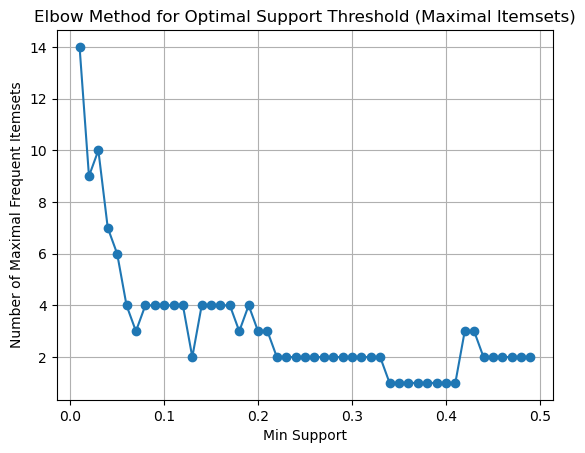

In [74]:
def get_maximal_itemsets_count(data_binary, min_support):
    """Computes the number of maximal frequent itemsets for a given support threshold."""
    frequent_itemsets = apriori(data_binary, min_support=min_support, use_colnames=True)
    max_itemsets = frequent_itemsets[
        ~frequent_itemsets["itemsets"].apply(
            lambda x: any(set(x).issubset(y) for y in frequent_itemsets["itemsets"] if set(x) != set(y))
        )
    ]
    return len(max_itemsets)

# Generate support values and compute maximal itemsets count
support_values = np.arange(0.01, 0.5, 0.01)
maximal_item_counts = [get_maximal_itemsets_count(data_binary, s) for s in support_values]

# Plot the elbow method for determining optimal support threshold
plt.plot(support_values, maximal_item_counts, marker="o")
plt.xlabel("Min Support")
plt.ylabel("Number of Maximal Frequent Itemsets")
plt.title("Elbow Method for Optimal Support Threshold (Maximal Itemsets)")
plt.grid(True)
plt.show()

In [75]:
def get_maximal_itemsets(data_binary, min_support):
    """
    Identifies maximal frequent itemsets for a given support threshold.

    Parameters:
    - data_binary (DataFrame): Binary-encoded dataset for association rule mining.
    - min_support (float): Minimum support threshold.

    Returns:
    - DataFrame: Maximal frequent itemsets.
    """
    frequent_itemsets = apriori(data_binary, min_support=min_support, use_colnames=True)

    # Identify maximal itemsets by ensuring no itemset is a subset of another
    maximal_itemsets = frequent_itemsets.loc[
        ~frequent_itemsets["itemsets"].apply(
            lambda x: any(set(x).issubset(y) for y in frequent_itemsets["itemsets"] if set(x) != set(y))
        )
    ]

    return maximal_itemsets


# Set minimum support value
min_support_value = 0.07

# Compute maximal frequent itemsets
maximal_itemsets_at_007 = get_maximal_itemsets(data_binary, min_support_value)

# Display results
print(f"Maximal Frequent Itemsets at min_support = {min_support_value}:\n")
display(maximal_itemsets_at_007)

Maximal Frequent Itemsets at min_support = 0.07:



,support,itemsets
15,0.073248,"(Science Fiction, Family)"
23,0.070064,"(Comedy, Adventure, Action, Family)"
24,0.130573,"(Comedy, Adventure, Family, Fantasy)"


In [76]:
# Append the maximal itemsets as new columns
for itemset in maximal_itemsets_at_007['itemsets']:
    column_name = ', '.join(itemset)  # Column name based on itemset
    data_binary[column_name] = data_binary[list(itemset)].all(axis=1).astype(int)

In [77]:
data_binary.columns

Index(['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'Thriller',
       'War', 'Western', 'Science Fiction, Family',
       'Comedy, Adventure, Action, Family',
       'Comedy, Adventure, Family, Fantasy'],
      dtype='object')

In [78]:
# Define a list of genres to remove from the dataset
columns_to_drop = [
    "Action", "Animation", "Adventure", "Comedy", "Crime", "Documentary", "Drama", 
    "Family", "Fantasy", "Horror", "History", "Music", "Mystery", "Romance", 
    "Science Fiction", "Thriller", "War", "Western",
]

# Drop the selected genre columns while ignoring errors if they don't exist
data_binary_cleaned = data_binary.drop(columns=columns_to_drop, errors="ignore")

# Restore "title" column to keep movie names in the cleaned dataset
data_binary_cleaned["title"] = df_genre["title"]

# Ensure "title" remains the first column while keeping other columns in order
column_order = ["title"] + [col for col in data_binary_cleaned.columns if col != "title"]
data_binary_cleaned = data_binary_cleaned[column_order]

# Display the first two rows of the cleaned dataset
data_binary_cleaned.head(2)

,title,"Science Fiction, Family","Comedy, Adventure, Action, Family","Comedy, Adventure, Family, Fantasy"
0,The Tigger Movie,0,0,0
1,Digimon: The Movie,1,0,0


In [79]:
# Identify movies that have no genre labels assigned (all zeros in genre columns)
all_zeros = data_binary_cleaned.loc[(data_binary_cleaned.iloc[:, 1:] == 0).all(axis=1)]
display(all_zeros.head(2))
print(f"Number of rows that have no genre labels assigned: {all_zeros.shape[0]}")

,title,"Science Fiction, Family","Comedy, Adventure, Action, Family","Comedy, Adventure, Family, Fantasy"
0,The Tigger Movie,0,0,0
3,Dinosaur,0,0,0


Number of rows that have no genre labels assigned: 239


In [80]:
# Compute the total count of each genre across all movies
column_sums = data_binary_cleaned.sum(numeric_only=True)

# Display the genre counts
print(column_sums)

Science Fiction, Family               23
Comedy, Adventure, Action, Family     22
Comedy, Adventure, Family, Fantasy    41
dtype: int64


In [81]:
# Identify movies that have no genre labels
all_zeros = data_binary_cleaned.loc[(data_binary_cleaned.iloc[:, 1:] == 0).all(axis=1)]

# Assign a new "genre_other" label to these movies
data_binary_cleaned.loc[all_zeros.index, "genre_other"] = 1

# Fill NaN values with 0 and ensure "genre_other" is an integer column
data_binary_cleaned["genre_other"] = data_binary_cleaned["genre_other"].fillna(0)
data_binary_cleaned["genre_other"] = data_binary_cleaned["genre_other"].astype(int)

In [82]:
# Recheck if any movies still have no genre labels assigned
all_zeros_check = data_binary_cleaned.loc[(data_binary_cleaned.iloc[:, 1:] == 0).all(axis=1)]
all_zeros_check.head(2)

,title,"Science Fiction, Family","Comedy, Adventure, Action, Family","Comedy, Adventure, Family, Fantasy",genre_other


In [83]:
# Recalculate the total count of each genre, including "genre_other"
column_sums_check = data_binary_cleaned.sum(numeric_only=True)

# Display the updated genre counts
print(column_sums_check)

Science Fiction, Family                23
Comedy, Adventure, Action, Family      22
Comedy, Adventure, Family, Fantasy     41
genre_other                           239
dtype: int64


In [84]:
data_binary_cleaned.columns

Index(['title', 'Science Fiction, Family', 'Comedy, Adventure, Action, Family',
       'Comedy, Adventure, Family, Fantasy', 'genre_other'],
      dtype='object')

In [85]:
# Merge the cleaned binary genre dataset back into df_animation_5 using "title" as the key
df_animation_7 = df_animation_6.merge(data_binary_cleaned, on="title", how="left")
# Remove the original separate genres, "genres_list" and "genres" columns as they are now encoded
df_animation_7 = df_animation_7.drop(columns_to_drop, axis=1)
df_animation_7 = df_animation_7.drop(["genres_list", 'genres'], axis=1)
# Display the first five rows of the final dataset
df_animation_7.head(5)

,id,title,original_language,overview,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,keywords,poster_path,backdrop_path,recommendations,release_year,production_companies_list,credits_list,quarter_q1,quarter_q2,quarter_q3,quarter_q4,release_quarter,real_budget,real_revenue,"Science Fiction, Family","Comedy, Adventure, Action, Family","Comedy, Adventure, Family, Fantasy",genre_other
0,15655,The Tigger Movie,en,Winnie the Pooh Piglet Owl Kanga Roo and Rabbi...,20.167,Walt Disney Pictures-Disney Television Animati...,2000-02-11,30000000.0,45554533.0,77.0,Released,NaN,6.500,487.0,Jim Cummings-Ken Sansom-John Fiedler-Peter Cul...,woman director,/lxuiGvLHIL1ZyePP7bn6FcKj0Mr.jpg,/uMoSM7r4dst4e5aFUhDEDPyh1hL.jpg,13691-13682-13706-16394-27332-14885-326911-511...,2000,"[Walt Disney Pictures, Disney Television Anima...","[Jim Cummings, Ken Sansom, John Fiedler, Peter...",1,0,0,0,Q1,6.281334e+07,9.538108e+07,0,0,0,1
1,20455,Digimon: The Movie,ja,The first story focused on Tai and Kari Kamiya...,13.017,Saban Entertainment-Toei Company-Fox Family Fi...,2000-03-04,5500000.0,16600000.0,89.0,Released,New Monsters. New Battles. Now on the Big Screen.,6.600,243.0,Lara Jill Miller-Joshua Seth-Bob Papenbrook-Da...,video game-monster-loss of energy-computer-sup...,/1MpgVWRCdWEgu9qZivyNX4glDe.jpg,/1ZFUt0LtYkF568iCkRXCScgBP5g.jpg,97787-75571-12599-98299-10228-10991-36201-8873...,2000,"[Saban Entertainment, Toei Company, Fox Family...","[Lara Jill Miller, Joshua Seth, Bob Papenbrook...",1,0,0,0,Q1,1.151578e+07,3.475671e+07,1,0,0,0
2,10501,The Road to El Dorado,en,After a failed swindle two con-men end up with...,41.768,DreamWorks Animation-DreamWorks Pictures,2000-03-31,95000000.0,76432727.0,89.0,Released,They came for the gold. They stayed for the ad...,7.242,3354.0,Kenneth Branagh-Kevin Kline-Rosie Perez-Armand...,gold-horse-musical-cartoon-sword fight-con art...,/ryXm7xp4aqQyda0FU2eMfHehPBg.jpg,/ciID0Mu1pPuOUP3JbOsDXQ5aMV6.jpg,10865-8916-10009-9837-9444-14411-11688-9023-90...,2000,"[DreamWorks Animation, DreamWorks Pictures]","[Kenneth Branagh, Kevin Kline, Rosie Perez, Ar...",1,0,0,0,Q1,1.989089e+08,1.600332e+08,0,0,1,0
3,10567,Dinosaur,en,An orphaned dinosaur raised by lemurs joins an...,62.622,Walt Disney Pictures-Walt Disney Feature Anima...,2000-05-19,127500000.0,354248063.0,82.0,Released,Discover a world you've only imagined.,6.534,2455.0,D.B. Sweeney-Alfre Woodard-Ossie Davis-Max Cas...,cataclysm-asteroid-leader-villain-comet-migrat...,/rSje3FS7ycJSglowlngjsvDt7vO.jpg,/laeEtakR2pLKu3CeRwB2lU5Y53X.jpg,12129-7443-11688-10865-13691-49948-15655-12233...,2000,"[Walt Disney Pictures, Walt Disney Feature Ani...","[D.B. Sweeney, Alfre Woodard, Ossie Davis, Max...",0,1,0,0,Q2,2.669567e+08,7.417168e+08,0,0,0,1
4,7450,Titan A.E.,en,A young man finds out that he holds the key to...,19.759,20th Century Fox-David Kirschner Productions-F...,2000-06-16,75000000.0,36754634.0,94.0,Released,"When Earth Ends, The Adventure Begins.",6.609,916.0,Matt Damon-Bill Pullman-Drew Barrymore-John Le...,monster-galaxy-dystopia-space-alien-mission,/el2iHk3LTJWfEnwrvcRkvWY501G.jpg,/pniACHS8KDVCldB3BlwL78RIZ7V.jpg,9016-14411-2114-9837-10016-2157-8584-13225-97-...,2000,"[20th Century Fox, David Kirschner Productions...","[Matt Damon, Bill Pullman, Drew Barrymore, Joh...",0,1,0,0,Q2,1.570333e+08,7.695604e+07,1,0,0,0


In [86]:
# # Extract maximal itemsets as lists of genres (sorted to handle order variations)
# maximally_frequent_itemsets = maximal_itemsets_at_007["itemsets"].apply(lambda x: set(x)).tolist()

# # Merge the cleaned binary genre dataset back into df_animation_5 using "title" as the key
# df_animation_7 = df_animation_6.merge(data_binary_cleaned, on="title", how="left")

# # Create structured genre features
# df_animation_7["Genre_Family"] = df_animation_7["Family"].astype(int)

# df_animation_7["Genre_Comedy_Adventure"] = (
#     (df_animation_7["Comedy"] == 1) & (df_animation_7["Adventure"] == 1)
# ).astype(int)

# df_animation_7["Genre_Action_Only"] = (
#     (df_animation_7["Action"] == 1) & (df_animation_7["Fantasy"] == 0) & (df_animation_7["Science Fiction"] == 0)
# ).astype(int)

# df_animation_7["Genre_Fantasy_Only"] = (
#     (df_animation_7["Fantasy"] == 1) & (df_animation_7["Action"] == 0) & (df_animation_7["Science Fiction"] == 0)
# ).astype(int)

# df_animation_7["Genre_SciFi_Only"] = (
#     (df_animation_7["Science Fiction"] == 1) & (df_animation_7["Action"] == 0) & (df_animation_7["Fantasy"] == 0)
# ).astype(int)

# # Drop the individual genre columns
# df_animation_7 = df_animation_7.drop(columns=columns_to_drop, errors="ignore")

# # Identify actual columns in df_animation_7 that match the maximal itemsets
# new_columns_to_drop = [
#     col for col in df_animation_7.columns 
#     if set(col.split(", ")) in maximally_frequent_itemsets  # Check if the column matches any maximal itemset
# ]

# # Drop the dynamically identified maximally frequent itemset columns
# df_animation_7 = df_animation_7.drop(columns=new_columns_to_drop, errors="ignore")

# # Drop original genre columns and unneeded lists
# df_animation_7 = df_animation_7.drop(["genres_list", "genres"], axis=1)

# # Display the first five rows of the final dataset
# df_animation_7.head(5)

### Original Language

We analyze the distribution of movie languages and apply a **cutoff based on the elbow method** to retain only the **top 2 most common languages**, categorizing the rest as **"other"**.

**Why Apply a Cutoff?**
- **Most movies are in a few dominant languages**, while others have low representation.
- **Reduces dimensionality** by avoiding excessive one-hot encoding for rare languages.
- **Improves interpretability** by focusing on major language trends.

After identifying the top 2 languages, we apply **one-hot encoding** to convert the categorical variable into a binary format.


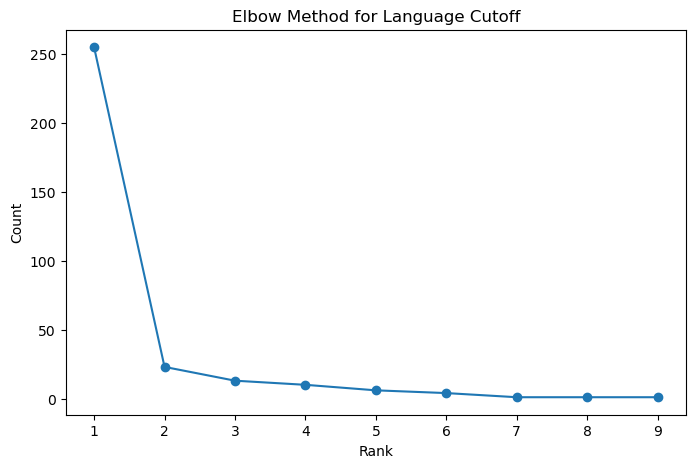

In [87]:
# Compute language frequency counts
language_counts = df_animation_7["original_language"].value_counts().values

# Plot rank vs. count to determine an optimal cutoff
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(language_counts) + 1), language_counts, marker="o")

# Add labels and title
plt.title("Elbow Method for Language Cutoff")
plt.xlabel("Rank")
plt.ylabel("Count")

# Show plot
plt.show()

In [88]:
# Define the number of top languages to retain
top_n = 2

# Extract the most frequent languages based on the elbow point
top_languages = df_animation_7["original_language"].value_counts().nlargest(top_n).index

# Display the selected top languages
print("Top Languages based on Elbow Point:", top_languages)

Top Languages based on Elbow Point: Index(['en', 'ja'], dtype='object', name='original_language')


In [89]:
# Replace less common languages with "other"
df_animation_8 = df_animation_7.copy()
df_animation_8["original_language"] = df_animation_8["original_language"].apply(
    lambda x: x if x in top_languages else "other"
)

In [90]:
# One-hot encode the original language column
df_animation_8 = pd.get_dummies(df_animation_8, columns=["original_language"], dtype=int)
df_animation_8.head(5)

,id,title,overview,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,keywords,poster_path,backdrop_path,recommendations,release_year,production_companies_list,credits_list,quarter_q1,quarter_q2,quarter_q3,quarter_q4,release_quarter,real_budget,real_revenue,"Science Fiction, Family","Comedy, Adventure, Action, Family","Comedy, Adventure, Family, Fantasy",genre_other,original_language_en,original_language_ja,original_language_other
0,15655,The Tigger Movie,Winnie the Pooh Piglet Owl Kanga Roo and Rabbi...,20.167,Walt Disney Pictures-Disney Television Animati...,2000-02-11,30000000.0,45554533.0,77.0,Released,NaN,6.500,487.0,Jim Cummings-Ken Sansom-John Fiedler-Peter Cul...,woman director,/lxuiGvLHIL1ZyePP7bn6FcKj0Mr.jpg,/uMoSM7r4dst4e5aFUhDEDPyh1hL.jpg,13691-13682-13706-16394-27332-14885-326911-511...,2000,"[Walt Disney Pictures, Disney Television Anima...","[Jim Cummings, Ken Sansom, John Fiedler, Peter...",1,0,0,0,Q1,6.281334e+07,9.538108e+07,0,0,0,1,1,0,0
1,20455,Digimon: The Movie,The first story focused on Tai and Kari Kamiya...,13.017,Saban Entertainment-Toei Company-Fox Family Fi...,2000-03-04,5500000.0,16600000.0,89.0,Released,New Monsters. New Battles. Now on the Big Screen.,6.600,243.0,Lara Jill Miller-Joshua Seth-Bob Papenbrook-Da...,video game-monster-loss of energy-computer-sup...,/1MpgVWRCdWEgu9qZivyNX4glDe.jpg,/1ZFUt0LtYkF568iCkRXCScgBP5g.jpg,97787-75571-12599-98299-10228-10991-36201-8873...,2000,"[Saban Entertainment, Toei Company, Fox Family...","[Lara Jill Miller, Joshua Seth, Bob Papenbrook...",1,0,0,0,Q1,1.151578e+07,3.475671e+07,1,0,0,0,0,1,0
2,10501,The Road to El Dorado,After a failed swindle two con-men end up with...,41.768,DreamWorks Animation-DreamWorks Pictures,2000-03-31,95000000.0,76432727.0,89.0,Released,They came for the gold. They stayed for the ad...,7.242,3354.0,Kenneth Branagh-Kevin Kline-Rosie Perez-Armand...,gold-horse-musical-cartoon-sword fight-con art...,/ryXm7xp4aqQyda0FU2eMfHehPBg.jpg,/ciID0Mu1pPuOUP3JbOsDXQ5aMV6.jpg,10865-8916-10009-9837-9444-14411-11688-9023-90...,2000,"[DreamWorks Animation, DreamWorks Pictures]","[Kenneth Branagh, Kevin Kline, Rosie Perez, Ar...",1,0,0,0,Q1,1.989089e+08,1.600332e+08,0,0,1,0,1,0,0
3,10567,Dinosaur,An orphaned dinosaur raised by lemurs joins an...,62.622,Walt Disney Pictures-Walt Disney Feature Anima...,2000-05-19,127500000.0,354248063.0,82.0,Released,Discover a world you've only imagined.,6.534,2455.0,D.B. Sweeney-Alfre Woodard-Ossie Davis-Max Cas...,cataclysm-asteroid-leader-villain-comet-migrat...,/rSje3FS7ycJSglowlngjsvDt7vO.jpg,/laeEtakR2pLKu3CeRwB2lU5Y53X.jpg,12129-7443-11688-10865-13691-49948-15655-12233...,2000,"[Walt Disney Pictures, Walt Disney Feature Ani...","[D.B. Sweeney, Alfre Woodard, Ossie Davis, Max...",0,1,0,0,Q2,2.669567e+08,7.417168e+08,0,0,0,1,1,0,0
4,7450,Titan A.E.,A young man finds out that he holds the key to...,19.759,20th Century Fox-David Kirschner Productions-F...,2000-06-16,75000000.0,36754634.0,94.0,Released,"When Earth Ends, The Adventure Begins.",6.609,916.0,Matt Damon-Bill Pullman-Drew Barrymore-John Le...,monster-galaxy-dystopia-space-alien-mission,/el2iHk3LTJWfEnwrvcRkvWY501G.jpg,/pniACHS8KDVCldB3BlwL78RIZ7V.jpg,9016-14411-2114-9837-10016-2157-8584-13225-97-...,2000,"[20th Century Fox, David Kirschner Productions...","[Matt Damon, Bill Pullman, Drew Barrymore, Joh...",0,1,0,0,Q2,1.570333e+08,7.695604e+07,1,0,0,0,1,0,0


### Production Companies and Actors

**TrueSkill Ratings for Production Companies and Actors**

**What is TrueSkill?**
    
TrueSkill is a **Bayesian ranking system** developed by Microsoft Research in **2005** to rank players in competitive games, originally for **Xbox Live matchmaking**. It improves upon the **Elo rating system** by handling **multiplayer scenarios** and dynamically adjusting uncertainty in rankings. 

**Why Use TrueSkill for Movies?**
    
We apply TrueSkill to **rank production companies and actors** based on their historical movie performances. Unlike traditional ranking systems, TrueSkill **continuously updates** as new data becomes available, providing a more accurate reflection of past success.

**How TrueSkill Works in This Context**
1. **Production Companies (`companies_trueskill`)**  
   - Companies gain higher ratings when they are associated with **financially successful movies**.
   - The system accounts for **competition** (e.g., multiple production companies per movie).

2. **Actors (`credits_trueskill`)**  
   - Measures an actor’s historical performance based on the **success of movies they've worked on**.
   - TrueSkill adjusts **for uncertainty**, meaning that actors with few roles start with a wider confidence range.

**Why TrueSkill Instead of Elo?**
- **Handles multiple entities per movie** (e.g., multiple companies and actors contributing to success).
- **Prevents data leakage** by updating ratings sequentially **only as past movies are processed**.
- **Balances risk vs. reward**, allowing **new actors and companies to rise in rankings quickly** if they contribute to highly successful films.

In [91]:
class TrueSkillManager:
    def __init__(self, mu=25, sigma=8.33, beta=4.167, tau=0.083, draw_probability=0.1):
        # Initialize TrueSkill environment
        self.env = ts.TrueSkill(mu=mu, sigma=sigma, beta=beta, tau=tau, draw_probability=draw_probability)
        self.ratings_df = pd.DataFrame(columns=['entity', 'role', 'mu', 'sigma', 'last_updated'])
    
    def _get_or_create_rating(self, entity, role, date):
        """Retrieves or initializes a rating for a company or actor."""
        existing = self.ratings_df[(self.ratings_df['entity'] == entity) & (self.ratings_df['role'] == role) & (self.ratings_df['last_updated'] <= date)]
        if not existing.empty:
            row = existing.sort_values(by='last_updated', ascending=False).iloc[0]
            return ts.Rating(mu=row['mu'], sigma=row['sigma'])
        else:
            return self.env.create_rating()
    
    def update_ratings(self, movie_data):
        """Updates TrueSkill ratings based on a single movie."""
        budget, revenue, release_date = movie_data['budget'], movie_data['revenue'], movie_data['release_date']
        
        # Ensure production_companies and credits are strings, else replace with an empty string
        production_companies = str(movie_data['production_companies']) if pd.notna(movie_data['production_companies']) else ""
        credits = str(movie_data['credits']) if pd.notna(movie_data['credits']) else ""
        
        # Extract and clean production companies & actors
        companies = [comp.strip() for comp in production_companies.split('-') if comp.strip()]
        actors = [act.strip() for act in credits.split('-') if act.strip()]

        # Determine movie success (win/loss/mid-ground condition)
        if revenue >= 2.5 * budget:
            success = 1  # Win
        elif revenue >= budget:
            success = 0.5  # Mid-ground
        else:
            success = 0  # Loss

        # Sort ratings DataFrame by date to ensure chronological updates
        self.ratings_df = self.ratings_df.sort_values(by='last_updated', ascending=True)

        # Get current ratings
        company_ratings = [self._get_or_create_rating(comp, 'company', release_date) for comp in companies]
        actor_ratings = [self._get_or_create_rating(act, 'actor', release_date) for act in actors]

        # Introduce a dummy competitor (always present)
        dummy_team = [self.env.create_rating()]
        
        # Always compare against the dummy team
        company_ratings.append(dummy_team[0])
        actor_ratings.append(dummy_team[0])

        # Compute new TrueSkill ratings (always compared against dummy)
        new_companies, _ = self.env.rate([company_ratings, dummy_team], ranks=[1-success, success])
        new_actors, _ = self.env.rate([actor_ratings, dummy_team], ranks=[1-success, success])

        # Store historical ratings instead of overwriting past data
        for comp, new_rating in zip(companies, new_companies[:-1]):  # Exclude dummy team
            new_entry = pd.DataFrame([{
                'entity': comp, 'role': 'company', 'mu': new_rating.mu, 'sigma': new_rating.sigma, 'last_updated': release_date
            }])
            if self.ratings_df.empty:
                self.ratings_df = new_entry
            else:
                self.ratings_df = pd.concat([self.ratings_df, new_entry], ignore_index=True)

        for act, new_rating in zip(actors, new_actors[:-1]):  # Exclude dummy team
            new_entry = pd.DataFrame([{
                'entity': act, 'role': 'actor', 'mu': new_rating.mu, 'sigma': new_rating.sigma, 'last_updated': release_date
            }])
            if self.ratings_df.empty:
                self.ratings_df = new_entry
            else:
                self.ratings_df = pd.concat([self.ratings_df, new_entry], ignore_index=True)
    
    def get_ratings(self):
        """Returns the latest TrueSkill ratings as a DataFrame."""
        return self.ratings_df.copy()
    
    def get_rating_at_time(self, entities, role, date):
        """Retrieve the TrueSkill rating (μ) for a specific entity or group at a given point in time."""
        if isinstance(entities, str):
            entities = [entities]  # Convert to list if a single entity is provided

        # Query the historical ratings at or before the given date
        ratings = self.ratings_df.query(
            "entity in @entities & role == @role & last_updated < @date"
        ).sort_values(by="last_updated", ascending=False).drop_duplicates(subset=["entity"])

        if ratings.empty:
            return f"No rating available for {entities} as of {date}."
        
        return ratings["mu"].mean()  # Return the average if multiple entities are provided
    
    def save_state(self, filepath):
        """Saves the TrueSkill ratings to a CSV file."""
        self.ratings_df.to_csv(filepath, index=False)
    
    def load_state(self, filepath):
        """Loads TrueSkill ratings from a CSV file."""
        self.ratings_df = pd.read_csv(filepath)

    def add_trueskill_features(self, df):
        """Adds historical TrueSkill features to the dataset based on release date."""
        df['companies_trueskill'] = df.apply(
            lambda row: (
                self.ratings_df.query(
                    "entity in @row.production_companies.split('-') & role == 'company' & last_updated < @row.release_date"
                )['mu'].mean()
                if not self.ratings_df.query(
                    "entity in @row.production_companies.split('-') & role == 'company' & last_updated < @row.release_date"
                ).empty
                else 25  # Default TrueSkill μ for new entities
            ) if isinstance(row.production_companies, str) and row.production_companies.strip() else 25,
            axis=1
        )

        df['credits_trueskill'] = df.apply(
            lambda row: (
                self.ratings_df.query(
                    "entity in @row.credits.split('-') & role == 'actor' & last_updated < @row.release_date"
                )['mu'].mean()
                if not self.ratings_df.query(
                    "entity in @row.credits.split('-') & role == 'actor' & last_updated < @row.release_date"
                ).empty
                else 25  # Default TrueSkill μ for new actors
            ) if isinstance(row.credits, str) and row.credits.strip() else 25,
            axis=1
        )
        return df


In [92]:
# Create a TrueSkill object
ts_manager = TrueSkillManager()

# Process each movie in sequential order
for _, row in df_animation_5.iterrows():
    ts_manager.update_ratings(row)

# Add TrueSkill features to the main DataFrame
df_animation_9 = df_animation_8.copy()
df_animation_9 = ts_manager.add_trueskill_features(df_animation_9)

# Display the first few rows to verify
df_animation_9[["title", "release_date", "production_companies", 
                "companies_trueskill", "credits", "credits_trueskill"]]

,title,release_date,production_companies,companies_trueskill,credits,credits_trueskill
0,The Tigger Movie,2000-02-11,Walt Disney Pictures-Disney Television Animati...,25.000000,Jim Cummings-Ken Sansom-John Fiedler-Peter Cul...,25.000000
1,Digimon: The Movie,2000-03-04,Saban Entertainment-Toei Company-Fox Family Fi...,25.000000,Lara Jill Miller-Joshua Seth-Bob Papenbrook-Da...,25.000000
2,The Road to El Dorado,2000-03-31,DreamWorks Animation-DreamWorks Pictures,25.000000,Kenneth Branagh-Kevin Kline-Rosie Perez-Armand...,8.097407
3,Dinosaur,2000-05-19,Walt Disney Pictures-Walt Disney Feature Anima...,13.014667,D.B. Sweeney-Alfre Woodard-Ossie Davis-Max Cas...,25.000000
4,Titan A.E.,2000-06-16,20th Century Fox-David Kirschner Productions-F...,25.000000,Matt Damon-Bill Pullman-Drew Barrymore-John Le...,0.602939
...,...,...,...,...,...,...
309,Teenage Mutant Ninja Turtles: Mutant Mayhem,2023-07-31,Paramount-Nickelodeon Movies-Point Grey Pictur...,3.444722,Micah Abbey-Shamon Brown Jr.-Nicolas Cantu-Bra...,13.361342
310,PAW Patrol: The Mighty Movie,2023-09-21,Nickelodeon Movies-Spin Master-Paramount Pictu...,6.782089,Mckenna Grace-Christian Convery-Taraji P. Hens...,10.813690
311,Migration,2023-12-06,Illumination,27.229222,Kumail Nanjiani-Elizabeth Banks-Caspar Jenning...,-7.325272
312,The Garfield Movie,2024-04-30,Alcon Entertainment-DNEG-Wayfarer Studios-One ...,25.000000,Chris Pratt-Samuel L. Jackson-Hannah Waddingha...,10.527359


In [93]:
# Display all column names in the processed dataset
df_animation_9.columns

Index(['id', 'title', 'overview', 'popularity', 'production_companies',
       'release_date', 'budget', 'revenue', 'runtime', 'status', 'tagline',
       'vote_average', 'vote_count', 'credits', 'keywords', 'poster_path',
       'backdrop_path', 'recommendations', 'release_year',
       'production_companies_list', 'credits_list', 'quarter_q1', 'quarter_q2',
       'quarter_q3', 'quarter_q4', 'release_quarter', 'real_budget',
       'real_revenue', 'Science Fiction, Family',
       'Comedy, Adventure, Action, Family',
       'Comedy, Adventure, Family, Fantasy', 'genre_other',
       'original_language_en', 'original_language_ja',
       'original_language_other', 'companies_trueskill', 'credits_trueskill'],
      dtype='object')

In [94]:
# Select movies produced by Pixar and Walt Disney Pictures
pixar_disney_movies = df_animation_9[
    df_animation_9["production_companies"].str.contains("Pixar-Walt Disney Pictures", na=False)
]

# Display relevant columns for analysis
pixar_disney_movies[
    ["title", "release_date", "production_companies", "companies_trueskill", "credits", "credits_trueskill"]
]

,title,release_date,production_companies,companies_trueskill,credits,credits_trueskill
42,The Incredibles,2004-10-27,Pixar-Walt Disney Pictures,8.769639,Craig T. Nelson-Holly Hunter-Sarah Vowell-Spen...,4.604792
60,Cars,2006-06-08,Pixar-Walt Disney Pictures,6.570978,Owen Wilson-Larry the Cable Guy-Bonnie Hunt-Pa...,2.734665
77,Ratatouille,2007-06-28,Pixar-Walt Disney Pictures,6.216211,Patton Oswalt-Lou Romano-Ian Holm-Brian Denneh...,14.576500
88,WALL·E,2008-06-22,Pixar-Walt Disney Pictures,6.564252,Ben Burtt-Elissa Knight-Jeff Garlin-Fred Willa...,0.060011
113,Toy Story 3,2010-06-16,Pixar-Walt Disney Pictures,5.377186,Tom Hanks-Tim Allen-Joan Cusack-Don Rickles-Wa...,-2.928563
160,Monsters University,2013-06-19,Pixar-Walt Disney Pictures,4.282338,Billy Crystal-John Goodman-Steve Buscemi-Helen...,-3.755147
201,Inside Out,2015-06-17,Pixar-Walt Disney Pictures,3.233401,Amy Poehler-Phyllis Smith-Richard Kind-Bill Ha...,1.058259
217,Finding Dory,2016-06-16,Pixar-Walt Disney Pictures,3.771753,Albert Brooks-Ellen DeGeneres-Ed O'Neill-Hayde...,16.379667
244,Coco,2017-10-27,Pixar-Walt Disney Pictures,4.101561,Anthony Gonzalez-Gael García Bernal-Benjamin B...,15.718141
287,Luca,2021-06-17,Pixar-Walt Disney Pictures,3.976995,Jacob Tremblay-Jack Dylan Grazer-Emma Berman-S...,13.281064


### Keywords

**Why Use Frequency for Keyword Selection?**
We use **keyword frequency** to identify the most relevant keywords for animated movies. Instead of using all keywords, which may include rare or noisy terms, frequency-based selection helps us:
- **Reduce dimensionality** by focusing only on commonly occurring themes.
- **Improve model interpretability** by selecting keywords that are more representative of the dataset.
- **Avoid overfitting** by preventing the model from learning from rare, uninformative keywords.

**Why Not Use TF-IDF Instead?**
While **TF-IDF** is useful for document classification, it **downweights common words**, which is not ideal for our case. Since we want to capture **frequently recurring themes** in animated movies (e.g., "friendship," "magic"), using raw frequency ensures we **prioritize the most dominant themes**.

**Process Overview**
1. **Preprocess keywords**: Convert text to lowercase and remove special characters.
2. **Convert to Bag-of-Words representation**: Extract keyword frequency.
3. **Plot an elbow curve**: Identify the most meaningful keywords based on a natural cutoff.
4. **Multi-label binarization**: Create binary features for the **top 12 most frequent keywords**.


In [95]:
# Convert keywords to lowercase and remove special characters
def preprocess_keywords(keyword_list):
    return [re.sub(r"[^a-zA-Z0-9\s]", "", kw.lower()) for kw in keyword_list]


# Convert keyword lists into binary columns for the top N keywords
def multi_label_binarize_keywords(keyword_list, top_keywords):
    return {kw: int(kw in keyword_list) for kw in top_keywords}

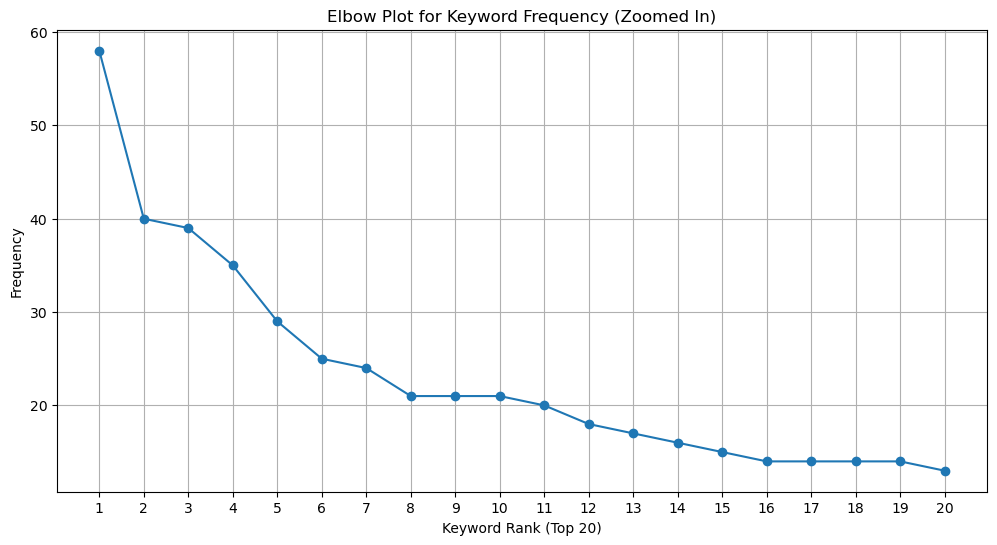

In [96]:
# Create a copy of the dataset
df_animation_10 = df_animation_9.copy()

# Convert dash-separated keyword strings to lists
df_animation_10["split_keywords"] = df_animation_10["keywords"].apply(dash_str_to_list)

# Clean the keywords using preprocessing function
df_animation_10["clean_keywords"] = df_animation_10["split_keywords"].apply(preprocess_keywords)

# Convert to Bag-of-Words representation
vectorizer = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, stop_words="english")
X = vectorizer.fit_transform(df_animation_10["clean_keywords"])

# Compute keyword frequencies
word_counts = X.toarray().sum(axis=0)
words = vectorizer.get_feature_names_out()
word_freq = pd.DataFrame({"word": words, "count": word_counts}).sort_values(by="count", ascending=False)

# Plot elbow curve for the top 20 keywords
plt.figure(figsize=(12, 6))
plt.plot(range(1, min(21, len(word_freq) + 1)), word_freq["count"].head(20), marker="o", linestyle="-")
plt.xticks(range(1, min(21, len(word_freq) + 1)))  # Ensure only whole numbers on x-axis
plt.xlabel("Keyword Rank (Top 20)")
plt.ylabel("Frequency")
plt.title("Elbow Plot for Keyword Frequency (Zoomed In)")
plt.grid(True)
plt.show()

In [97]:
# Select the top 12 most frequent keywords
top_keywords = word_freq["word"].head(12).tolist()

# Apply encoding to each movie
multi_label_encoded = df_animation_10["clean_keywords"].apply(lambda x: multi_label_binarize_keywords(x, top_keywords))

# Convert to DataFrame and merge with the dataset
multi_label_df = pd.DataFrame(list(multi_label_encoded))
df_animation_10 = pd.concat([df_animation_10, multi_label_df], axis=1)

In [98]:
# Display the first two rows
df_animation_10.head(2)

,id,title,overview,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,keywords,poster_path,backdrop_path,recommendations,release_year,production_companies_list,credits_list,quarter_q1,quarter_q2,quarter_q3,quarter_q4,release_quarter,real_budget,real_revenue,"Science Fiction, Family","Comedy, Adventure, Action, Family","Comedy, Adventure, Family, Fantasy",genre_other,original_language_en,original_language_ja,original_language_other,companies_trueskill,credits_trueskill,split_keywords,clean_keywords,duringcreditsstinger,aftercreditsstinger,sequel,anthropomorphism,friendship,cartoon,anime,animal,villain,family,superhero,dog
0,15655,The Tigger Movie,Winnie the Pooh Piglet Owl Kanga Roo and Rabbi...,20.167,Walt Disney Pictures-Disney Television Animati...,2000-02-11,30000000.0,45554533.0,77.0,Released,NaN,6.5,487.0,Jim Cummings-Ken Sansom-John Fiedler-Peter Cul...,woman director,/lxuiGvLHIL1ZyePP7bn6FcKj0Mr.jpg,/uMoSM7r4dst4e5aFUhDEDPyh1hL.jpg,13691-13682-13706-16394-27332-14885-326911-511...,2000,"[Walt Disney Pictures, Disney Television Anima...","[Jim Cummings, Ken Sansom, John Fiedler, Peter...",1,0,0,0,Q1,6.281334e+07,9.538108e+07,0,0,0,1,1,0,0,25.0,25.0,[woman director],[woman director],0,0,0,0,0,0,0,0,0,0,0,0
1,20455,Digimon: The Movie,The first story focused on Tai and Kari Kamiya...,13.017,Saban Entertainment-Toei Company-Fox Family Fi...,2000-03-04,5500000.0,16600000.0,89.0,Released,New Monsters. New Battles. Now on the Big Screen.,6.6,243.0,Lara Jill Miller-Joshua Seth-Bob Papenbrook-Da...,video game-monster-loss of energy-computer-sup...,/1MpgVWRCdWEgu9qZivyNX4glDe.jpg,/1ZFUt0LtYkF568iCkRXCScgBP5g.jpg,97787-75571-12599-98299-10228-10991-36201-8873...,2000,"[Saban Entertainment, Toei Company, Fox Family...","[Lara Jill Miller, Joshua Seth, Bob Papenbrook...",1,0,0,0,Q1,1.151578e+07,3.475671e+07,1,0,0,0,0,1,0,25.0,25.0,"[video game, monster, loss of energy, computer...","[video game, monster, loss of energy, computer...",0,0,0,0,0,0,1,0,0,0,1,0


In [99]:
df_animation_10.shape

(314, 51)

In [100]:
# Display all columns after keyword processing
df_animation_10.columns

Index(['id', 'title', 'overview', 'popularity', 'production_companies',
       'release_date', 'budget', 'revenue', 'runtime', 'status', 'tagline',
       'vote_average', 'vote_count', 'credits', 'keywords', 'poster_path',
       'backdrop_path', 'recommendations', 'release_year',
       'production_companies_list', 'credits_list', 'quarter_q1', 'quarter_q2',
       'quarter_q3', 'quarter_q4', 'release_quarter', 'real_budget',
       'real_revenue', 'Science Fiction, Family',
       'Comedy, Adventure, Action, Family',
       'Comedy, Adventure, Family, Fantasy', 'genre_other',
       'original_language_en', 'original_language_ja',
       'original_language_other', 'companies_trueskill', 'credits_trueskill',
       'split_keywords', 'clean_keywords', 'duringcreditsstinger',
       'aftercreditsstinger', 'sequel', 'anthropomorphism', 'friendship',
       'cartoon', 'anime', 'animal', 'villain', 'family', 'superhero', 'dog'],
      dtype='object')

In [101]:
# Export the processed dataset to a CSV file
df_animation_10.to_csv("animated_movies_dataset.csv", index=False)